In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

# Selection

In [2]:
dtypes = {
    "id": "string",
    "ra": "float32",
    "dec": "float32",
    # --- gaia ---
    "parallax": "float32",
    "gaia_ruwe": "float32",
    "gaia_parallax_over_error": "float32",
    "gaia_classprob_dsc_combmod_star": "float32",
    "gaia_in_qso_candidates": "int8",
    "gaia_in_galaxy_candidates": "int8",
    "gaia_phot_bp_rp_excess_factor": "float32",
    "err_mag_psf_u": "float32",
    "err_mag_psf_j0378": "float32",
    "err_mag_psf_j0395": "float32",
    "err_mag_psf_j0410": "float32",
    "err_mag_psf_j0430": "float32",
    "err_mag_psf_g": "float32",
    "err_mag_psf_j0515": "float32",
    "err_mag_psf_r": "float32",
    "err_mag_psf_j0660": "float32",
    "err_mag_psf_i": "float32",
    "err_mag_psf_j0861": "float32",
    "err_mag_psf_z": "float32",
    # --- magnitudes ---
    "mag_psf_u": "float32",
    "mag_psf_j0378": "float32",
    "mag_psf_j0395": "float32",
    "mag_psf_j0410": "float32",
    "mag_psf_j0430": "float32",
    "mag_psf_g": "float32",
    "mag_psf_j0515": "float32",
    "mag_psf_r": "float32",
    "mag_psf_j0660": "float32",
    "mag_psf_i": "float32",
    "mag_psf_j0861": "float32",
    "mag_psf_z": "float32"
    # --- erros magnitudes ---
    # "err_mag_pstotal_u": "float32",
    # "err_mag_pstotal_j0378": "float32",
    # "err_mag_pstotal_j0395": "float32",
    # "err_mag_pstotal_j0410": "float32",
    # "err_mag_pstotal_j0430": "float32",
    # "err_mag_pstotal_g": "float32",
    # "err_mag_pstotal_j0515": "float32",
    # "err_mag_pstotal_r": "float32",
    # "err_mag_pstotal_j0660": "float32",
    # "err_mag_pstotal_i": "float32",
    # "err_mag_pstotal_j0861": "float32",
    # "err_mag_pstotal_z": "float32",
    # # --- magnitudes ---
    # "mag_pstotal_u": "float32",
    # "mag_pstotal_j0378": "float32",
    # "mag_pstotal_j0395": "float32",
    # "mag_pstotal_j0410": "float32",
    # "mag_pstotal_j0430": "float32",
    # "mag_pstotal_g": "float32",
    # "mag_pstotal_j0515": "float32",
    # "mag_pstotal_r": "float32",
    # "mag_pstotal_j0660": "float32",
    # "mag_pstotal_i": "float32",
    # "mag_pstotal_j0861": "float32",
    # "mag_pstotal_z": "float32"

}


full = pd.read_csv(
    "/mnt/hdcasa/splus_gaia/oficial/MC.csv",
    engine="pyarrow",
    dtype=dtypes,
    usecols=list(dtypes.keys())
)

In [3]:
full = full[(full['err_mag_psf_j0660'] < 0.2)&
        (full['err_mag_psf_i'] < 0.2)&
        (full['err_mag_psf_r'] < 0.2)&
        (full['mag_psf_j0660']/full['err_mag_psf_j0660'] > 10)&
        (full['mag_psf_i']/full['err_mag_psf_i'] > 10)&
        (full['mag_psf_r']/full['err_mag_psf_r'] > 10)]
        # (full['gaia_ruwe'] < 1.4) &
        # (full['gaia_parallax_over_error'] > 3) &
        # (full['gaia_classprob_dsc_combmod_star'] > 0.5) &
        # (full['gaia_in_qso_candidates'] == 0) &
        # (full['gaia_in_galaxy_candidates'] == 0) &
        # (full['gaia_phot_bp_rp_excess_factor'].between(1.0, 1.3))]

In [ ]:
full= full[full['mag_psf_r'].between(13, 21)]

In [ ]:
len(full)

19224589

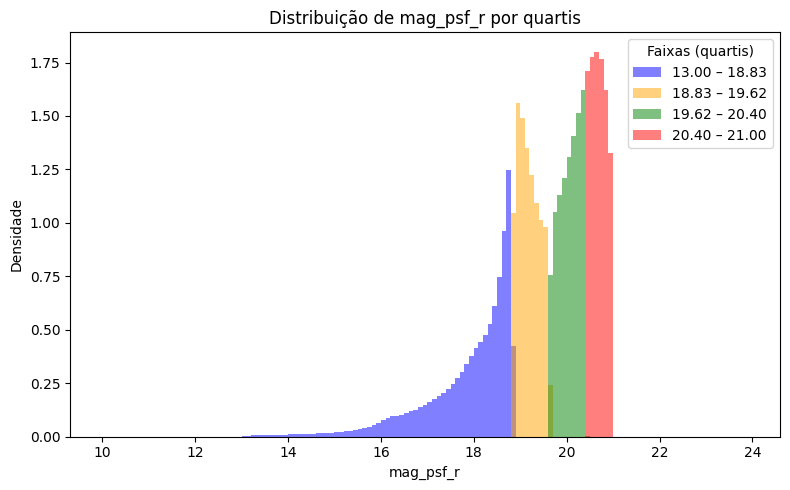

In [ ]:
# Quartis
quartis = np.percentile(full['mag_psf_r'], [25, 50, 75])
colors = ['blue', 'orange', 'green', 'red']

# Limites dos quartis (incluindo min e max)
q_bounds = [full['mag_psf_r'].min()] + quartis.tolist() + [full['mag_psf_r'].max()]

plt.figure(figsize=(8,5))

for i in range(4):
    lower = q_bounds[i]
    upper = q_bounds[i+1]

    if i == 0:
        subset = full[full['mag_psf_r'] <= upper]
    elif i == 3:
        subset = full[full['mag_psf_r'] > lower]
    else:
        subset = full[(full['mag_psf_r'] > lower) & (full['mag_psf_r'] <= upper)]

    plt.hist(
        subset['mag_psf_r'],
        bins=np.arange(10, 24, 0.1),
        density=True,
        alpha=0.5,
        color=colors[i],
        label=f'{lower:.2f} – {upper:.2f}'
    )

plt.xlabel('mag_psf_r')
plt.ylabel('Densidade')
plt.title('Distribuição de mag_psf_r por quartis')
plt.legend(title='Faixas (quartis)')
plt.tight_layout()
plt.show()

In [7]:
import numpy as np

def fit_basic_and_upper_envelope(x_series, y_series,
                                 k_lower=0.5, k_upper=3.0,
                                 max_iter=4, min_pts=20):
    """
    Calcula (sem plotar) um ajuste linear básico e um ajuste 'upper-envelope'
    via σ-clipping assimétrico.

    Parameters
    ----------
    x_series, y_series : array-like
        Dados de entrada.
    k_lower, k_upper : float
        Limiares (em sigmas) para o σ-clipping assimétrico (inferior/superior).
    max_iter : int
        Número máximo de iterações do σ-clipping.
    min_pts : int
        Mínimo de pontos para manter o ajuste estável.

    Returns
    -------
    result : dict
        {
          'n_init': int,                 # pontos válidos iniciais
          'basic': {
              'ok': bool,
              'm': float or None,
              'b': float or None
          },
          'upper': {
              'ok': bool,
              'm': float or None,
              'b': float or None,
              'n_final': int or None,    # pontos após clipping
              'iters': int,              # iterações realizadas
              'mask_used': np.ndarray or None  # máscara (sobre válidos) dos pontos retidos
          },
          'x_domain': (float, float)     # (xmin, xmax) úteis
        }
    """
    # --- limpeza
    x = np.asarray(x_series, dtype=float)
    y = np.asarray(y_series, dtype=float)
    valid = np.isfinite(x) & np.isfinite(y)
    x, y = x[valid], y[valid]
    n_init = x.size

    xmin = float(np.min(x)) if n_init else np.nan
    xmax = float(np.max(x)) if n_init else np.nan

    result = {
        'n_init': int(n_init),
        'basic': {'ok': False, 'm': None, 'b': None},
        'upper': {'ok': False, 'm': None, 'b': None, 'n_final': None, 'iters': 0, 'mask_used': None},
        'x_domain': (xmin, xmax),
    }

    # --- ajuste básico
    if n_init >= 2 and not np.isclose(x.std(), 0.0):
        try:
            m_basic, b_basic = np.polyfit(x, y, 1)
            result['basic'] = {'ok': True, 'm': float(m_basic), 'b': float(b_basic)}
        except np.linalg.LinAlgError:
            pass  # mantém ok=False

    # --- upper-envelope (σ-clipping assimétrico)
    if n_init >= max(min_pts, 2) and not np.isclose(x.std(), 0.0):
        try:
            m, b = np.polyfit(x, y, 1)
            keep = np.ones_like(x, dtype=bool)
            prev_n = x.size
            iters = 0

            for it in range(max_iter):
                r = y - (m * x + b)
                mad = np.median(np.abs(r - np.median(r)))
                sigma = 1.4826 * mad if mad > 0 else r.std()
                if not np.isfinite(sigma) or sigma == 0:
                    break

                keep = (r > -k_lower * sigma) & (r < k_upper * sigma)
                if keep.sum() < min_pts or keep.sum() == prev_n:
                    iters = it + 1
                    break

                x, y = x[keep], y[keep]
                prev_n = x.size
                iters = it + 1
                m, b = np.polyfit(x, y, 1)

            result['upper'] = {
                'ok': True,
                'm': float(m),
                'b': float(b),
                'n_final': int(x.size),
                'iters': int(iters),
                # máscara em relação ao conjunto válido original:
                'mask_used': keep if keep.shape[0] == valid.sum() else None
            }
        except np.linalg.LinAlgError:
            pass  # mantém ok=False

    return result


# (Opcional) Função de plot que usa o resultado já calculado
def plot_scatter_with_two_fits(ax, x_series, y_series, label,
                               color_upper='orange', color_basic='black',
                               fit_result=None, scatter=True):
    """
    Plota (opcionalmente) os pontos e as retas usando um 'fit_result' já calculado.
    Se 'fit_result' for None, calcula internamente.
    """
    x = np.asarray(x_series, dtype=float)
    y = np.asarray(y_series, dtype=float)
    valid = np.isfinite(x) & np.isfinite(y)
    x, y = x[valid], y[valid]

    if fit_result is None:
        fit_result = fit_basic_and_upper_envelope(x, y)

    if scatter:
        ax.scatter(x, y, s=0.5, label=label, color='white', alpha=0.3,
                   edgecolors='black', linewidths=0.1)

    xmin, xmax = fit_result['x_domain']
    if not np.isfinite([xmin, xmax]).all() or xmin == xmax:
        if x.size:
            xmin, xmax = x.min(), x.max()
        else:
            return  # nada a plotar
    x_fit = np.linspace(xmin, xmax, 100)

    # reta básica
    if fit_result['basic']['ok']:
        m, b = fit_result['basic']['m'], fit_result['basic']['b']
        ax.plot(x_fit, m * x_fit + b, lw=1, color=color_basic,
                label=f'Fit: y = {m:.2f}x + {b:.2f}')

    # reta upper-envelope
    if fit_result['upper']['ok']:
        m, b = fit_result['upper']['m'], fit_result['upper']['b']
        ax.plot(x_fit, m * x_fit + b, lw=1, linestyle='--', color=color_upper,
                label=f'Upper-σ: y = {m:.2f}x + {b:.2f}')

In [ ]:
# Máscaras
m1 = (full['mag_psf_r'] <= 18)
m2 = (full['mag_psf_r'] > 18) & (full['mag_psf_r'] <= 19)
m3 = (full['mag_psf_r'] > 19) & (full['mag_psf_r'] <= 20)
m4 = (full['mag_psf_r'] > 20) & (full['mag_psf_r'] <= 21)

def color_x(df):  # r - i
    return df['mag_psf_r'] - df['mag_psf_i']

def color_y(df):  # r - J0660
    return df['mag_psf_r'] - df['mag_psf_j0660']

results = {
    'r<=18': fit_basic_and_upper_envelope(color_x(full.loc[m1]), color_y(full.loc[m1])),
    '18<r<=19': fit_basic_and_upper_envelope(color_x(full.loc[m2]), color_y(full.loc[m2])),
    '19<r<=20': fit_basic_and_upper_envelope(color_x(full.loc[m3]), color_y(full.loc[m3])),
    '20<r<=21': fit_basic_and_upper_envelope(color_x(full.loc[m4]), color_y(full.loc[m4])),
}

# Exemplo de acesso:
for name, res in results.items():
    if res['upper']['ok']:
        print(name, 'upper:', res['upper']['m'], res['upper']['b'], 'n=', res['upper']['n_final'])
    if res['basic']['ok']:
        print(name, 'basic:', res['basic']['m'], res['basic']['b'])

r<=18 upper: 0.35916898721101936 0.01650892788363956 n= 276149
r<=18 basic: 0.3306884754153098 -0.0033041133429477787
18<r<=19 upper: 0.383278841994678 0.021545716213450035 n= 596934
18<r<=19 basic: 0.39668811924326836 -0.02565563230238524
19<r<=20 upper: 0.39469910292597615 0.03438636426348788 n= 836748
19<r<=20 basic: 0.42313283081748493 -0.04423275385530301
20<r<=21 upper: 0.3732619573692388 0.09776584484141748 n= 1169552
20<r<=21 basic: 0.4054158074243489 -0.05729511130371446


/tmp/ipykernel_311902/3907703963.py:119: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/marina/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


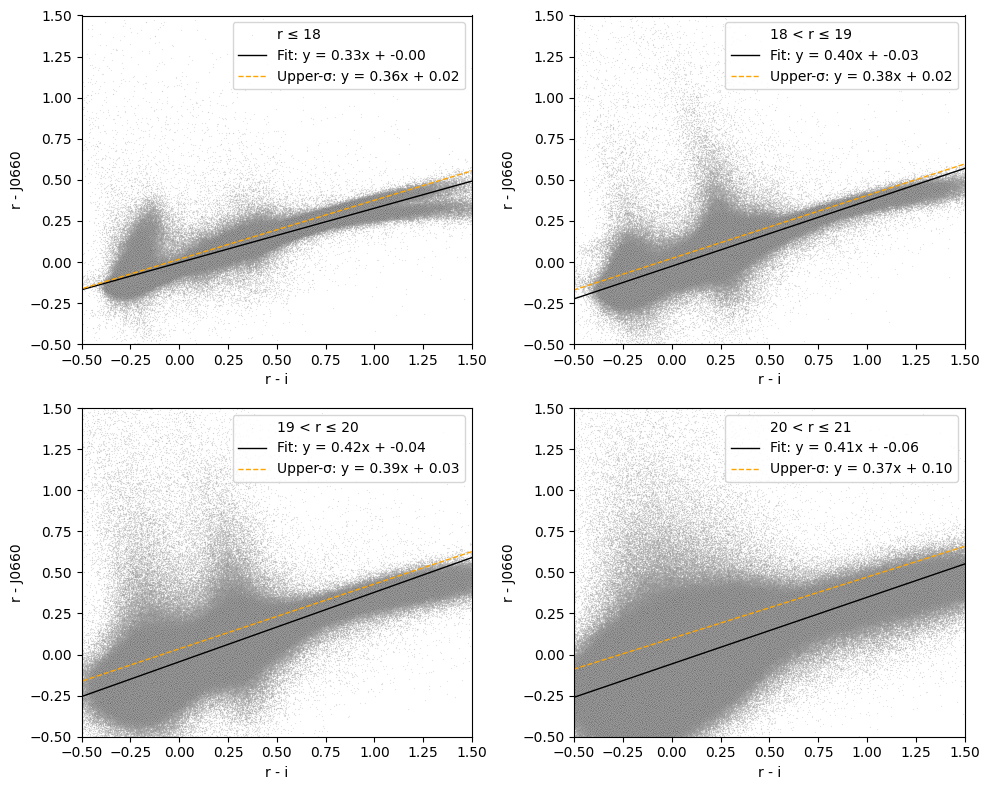

In [5]:
def plot_scatter_with_two_fits(ax, x_series, y_series, label,
                               color_upper='orange',
                               color_basic='black',
                               k_lower=0.5, k_upper=3.0,
                               max_iter=4, min_pts=20):
    """
    Plota pontos, um ajuste linear básico e um ajuste upper-envelope via σ-clipping iterativo.
    """

    # === Limpeza dos dados ===
    x = np.asarray(x_series, dtype=float)
    y = np.asarray(y_series, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # === Scatter plot ===
    ax.scatter(
        x, y, s=0.5,
        label=label,
        color='white',
        alpha=0.3,
        edgecolors='black',
        linewidths=0.1
    )

    # === Fit básico ===
    if x.size >= 2 and not np.isclose(x.std(), 0.0):
        try:
            m_basic, b_basic = np.polyfit(x, y, 1)
            xmin, xmax = ax.get_xlim()
            if not np.isfinite([xmin, xmax]).all() or xmin == xmax:
                xmin, xmax = (x.min(), x.max())
            x_fit = np.linspace(xmin, xmax, 100)
            y_fit = m_basic * x_fit + b_basic
            ax.plot(x_fit, y_fit, lw=1, color=color_basic,
                    label=f'Fit: y = {m_basic:.2f}x + {b_basic:.2f}')
        except np.linalg.LinAlgError:
            ax.text(0.02, 0.9, "Falha no ajuste (SVD)",
                    transform=ax.transAxes, va='top', ha='left', fontsize=8)
    else:
        ax.text(0.02, 0.95, "Sem variância/pts p/ ajuste",
                transform=ax.transAxes, va='top', ha='left', fontsize=8)

    # === Upper-envelope fit ===
    if x.size >= min_pts and not np.isclose(x.std(), 0.0):
        try:
            # Ajuste inicial
            m, b = np.polyfit(x, y, 1)
            prev_n = len(x)

            for _ in range(max_iter):
                r = y - (m * x + b)
                mad = np.median(np.abs(r - np.median(r)))
                sigma = 1.4826 * mad if mad > 0 else r.std()
                if not np.isfinite(sigma) or sigma == 0:
                    break

                keep = (r > -k_lower * sigma) & (r < k_upper * sigma)
                if keep.sum() < min_pts or keep.sum() == prev_n:
                    break

                x, y = x[keep], y[keep]
                prev_n = x.size

                m, b = np.polyfit(x, y, 1)

            xmin, xmax = ax.get_xlim()
            if not np.isfinite([xmin, xmax]).all() or xmin == xmax:
                xmin, xmax = (x.min(), x.max())
            x_fit = np.linspace(xmin, xmax, 100)
            y_fit = m * x_fit + b

            ax.plot(x_fit, y_fit, color=color_upper, lw=1, linestyle='--',
                    label=f'Upper-σ: y = {m:.2f}x + {b:.2f}')

        except np.linalg.LinAlgError:
            ax.text(0.02, 0.85, "Falha upper σ-fit",
                    transform=ax.transAxes, va='top', ha='left', fontsize=8)


# Defina as máscaras dos 4 bins em r
m1 = (full1['mag_psf_r'] <= 18)
m2 = (full1['mag_psf_r'] > 18) & (full1['mag_psf_r'] <= 19)
m3 = (full1['mag_psf_r'] > 19) & (full1['mag_psf_r'] <= 20)
m4 = (full1['mag_psf_r'] > 20) & (full1['mag_psf_r'] <= 21)

plt.figure(figsize=(10, 8))
ax1 = plt.subplot(221); ax2 = plt.subplot(222); ax3 = plt.subplot(223); ax4 = plt.subplot(224)

# Passe os subconjuntos diretamente (sem criar dataframes)
plot_scatter_with_two_fits(ax1,
    full1.loc[m1, 'mag_psf_r'] - full1.loc[m1, 'mag_psf_i'],
    full1.loc[m1, 'mag_psf_r'] - full1.loc[m1, 'mag_psf_j0660'],
    'r ≤ 18'
)
plot_scatter_with_two_fits(ax2,
    full1.loc[m2, 'mag_psf_r'] - full1.loc[m2, 'mag_psf_i'],
    full1.loc[m2, 'mag_psf_r'] - full1.loc[m2, 'mag_psf_j0660'],
    '18 < r ≤ 19'
)
plot_scatter_with_two_fits(ax3,
    full1.loc[m3, 'mag_psf_r'] - full1.loc[m3, 'mag_psf_i'],
    full1.loc[m3, 'mag_psf_r'] - full1.loc[m3, 'mag_psf_j0660'],
    '19 < r ≤ 20'
)
plot_scatter_with_two_fits(ax4,
    full1.loc[m4, 'mag_psf_r'] - full1.loc[m4, 'mag_psf_i'],
    full1.loc[m4, 'mag_psf_r'] - full1.loc[m4, 'mag_psf_j0660'],
    '20 < r ≤ 21'
)

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('r - i')
    ax.set_ylabel('r - J0660')
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlim(-0.5, 1.5)
    ax.legend()

plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utilidades ----------
def color_vectors_from_df(df, column_r ='mag_pstotal_r', column_i ='mag_pstotal_i', column_j ='mag_pstotal_j0660'):
    x = (df[column_r] - df[column_i]).to_numpy(float)       # (r - i)
    y = (df[column_r] - df[column_j]).to_numpy(float)   # (r - J0660)

    # erros individuais de magnitude
    er = df[f'err_{column_r}'].to_numpy(float)
    ei = df[f'err_{column_i}'].to_numpy(float)
    ej = df[f'err_{column_j}'].to_numpy(float)

    # erros das cores
    sig_x = np.sqrt(er**2 + ei**2)   # σ_(r-i)
    sig_y = np.sqrt(er**2 + ej**2)   # σ_(r-J0660)
    return x, y, sig_x, sig_y

def fit_upper_sigma_clipped(x, y, k_lower=0.5, k_upper=3.0, max_iter=4, min_pts=20):
    """Retorna m, b, rms e máscara final usada no ajuste (upper-envelope σ-clipping)."""
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if x.size < min_pts or np.isclose(x.std(), 0.0):
        return None, None, None, mask

    m, b = np.polyfit(x, y, 1)
    prev_n = len(x)
    for _ in range(max_iter):
        r = y - (m*x + b)
        mad = np.median(np.abs(r - np.median(r)))
        sigma = 1.4826*mad if mad > 0 else r.std()
        if not np.isfinite(sigma) or sigma == 0:
            break

        keep = (r > -k_lower*sigma) & (r < k_upper*sigma)
        if keep.sum() < min_pts or keep.sum() == prev_n:
            break
        x, y = x[keep], y[keep]
        prev_n = x.size
        m, b = np.polyfit(x, y, 1)

    # RMS dos resíduos (no conjunto final usado)
    resid = y - (m*x + b)
    rms = np.sqrt(np.mean(resid**2)) if resid.size else None
    # reconstrói máscara global (opcional)
    mask_final = np.isfinite(mask)
    return m, b, rms, mask_final

def select_halpha_emitters(x, y, sig_x, sig_y, m_fit, b_fit, rms, C=5.0):
    """
    Implementa Eq.(1) e Eq.(2):
      ΔHα = y - (m_fit*x + b_fit)
      ΔHα > C * sqrt(rms^2 + sig_y^2 + (m_fit^2) * sig_x^2)
    Retorna boolean mask 'emitters'.
    """
    y_fit = m_fit*x + b_fit
    delta = y - y_fit  # Eq. (1)
    thr   = C * np.sqrt((rms if rms is not None else 0.0)**2 + sig_y**2 + (m_fit**2) * sig_x**2)  # Eq. (2)
    emitters = delta > thr
    return delta, thr, emitters

# ---------- Plot integrando tudo (usa seu estilo) ----------
def plot_panel_eq12(ax, df, label,column_r, column_i, column_j,
                    k_lower=0.5, k_upper=3.0, max_iter=4, min_pts=20, C=5.0):
    # cores e erros
    x, y, sig_x, sig_y = color_vectors_from_df(df, column_r=column_r, column_i=column_i, column_j=column_j)

    # scatter base
    ax.scatter(x, y, s=0.5, color='white', alpha=0.3, edgecolors='black', linewidths=0.1, label=label)

    # ajusta locus (upper-envelope σ-clipping)
    m, b, rms, _ = fit_upper_sigma_clipped(x, y, k_lower, k_upper, max_iter, min_pts)
    if m is None:
        ax.text(0.02, 0.95, "Falha no ajuste", transform=ax.transAxes, va='top', ha='left')
        return

    # plota as retas (fit básico opcional; aqui só upper para foco nas Eq.1–2)
    xx = np.linspace(*ax.get_xlim(), 200) if np.isfinite(ax.get_xlim()).all() else np.linspace(x.min(), x.max(), 200)
    ax.plot(xx, m*xx + b, color='orange', lw=2, ls='--', label=f'Upper-σ fit: y={m:.2f}x+{b:.2f}')

    # Eq.(1) e Eq.(2): Δ e limiar ponto-a-ponto
    delta, thr, emitters = select_halpha_emitters(x, y, sig_x, sig_y, m, b, rms, C=C)
    df_emitters = df[emitters]
    # destaca emissores Hα
    ax.scatter(x[emitters], y[emitters], s=6, color='crimson', alpha=0.2, label=f'Hα emitters (C={C:g})')

    # linha de corte "média" para visualização (usa median(sig_x), median(sig_y))
    med_sig_x = np.median(sig_x[np.isfinite(sig_x)])
    med_sig_y = np.median(sig_y[np.isfinite(sig_y)])
    delta_med = C * np.sqrt((rms if rms is not None else 0.0)**2 + med_sig_y**2 + (m**2) * med_sig_x**2)
    ax.plot(xx, m*xx + b + delta_med, color='firebrick', lw=1.5, ls=':', label='Eq.(2) (mediana dos erros)')

    ax.legend()
    ax.set_xlabel('r - i')
    ax.set_ylabel('r - J0660')
    return ax, df_emitters

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Utilidades (mantidas) ----------
def color_vectors_from_df(df, column_r='mag_pstotal_r', column_i='mag_pstotal_i', column_j='mag_pstotal_j0660'):
    x = (df[column_r] - df[column_i]).to_numpy(float)       # (r - i)
    y = (df[column_r] - df[column_j]).to_numpy(float)       # (r - J0660)

    er = df[f'err_{column_r}'].to_numpy(float)
    ei = df[f'err_{column_i}'].to_numpy(float)
    ej = df[f'err_{column_j}'].to_numpy(float)

    sig_x = np.sqrt(er**2 + ei**2)   # σ_(r-i)
    sig_y = np.sqrt(er**2 + ej**2)   # σ_(r-J0660)
    return x, y, sig_x, sig_y

def select_halpha_emitters(x, y, sig_x, sig_y, m_fit, b_fit, rms, C=5.0):
    y_fit = m_fit*x + b_fit
    delta = y - y_fit
    rms_term = (rms if rms is not None else 0.0)
    thr = C * np.sqrt(rms_term**2 + sig_y**2 + (m_fit**2) * sig_x**2)
    emitters = delta > thr
    return delta, thr, emitters


# ---------- Versão que NÃO plota (só seleciona) ----------
def apply_eq12_select_emitters(df, column_r, column_i, column_j,
                               fit_result=None, m=None, b=None, rms=None, C=5.0,
                               panel_label=None):
    """
    Usa Eq.(1)-(2) para selecionar emissores de Hα, recebendo o fit já calculado.

    Você pode passar:
      - fit_result: dict como em {'basic':..., 'upper':{'m':..,'b':..}, '...','rms':...}
        (no mínimo precisa conter m, b, rms do ajuste escolhido)
      - ou diretamente m, b, rms.

    Retorna
    -------
    df_emitters : DataFrame
        Subconjunto de df com colunas auxiliares: 'ri', 'rJ0660', 'delta_Ha', 'thr', 'panel_label'
    """
    # Extrai parâmetros do fit
    if fit_result is not None:
        # tenta upper; se não houver, tenta basic
        if 'upper' in fit_result and fit_result['upper'].get('ok', False):
            m = fit_result['upper']['m']; b = fit_result['upper']['b']
        elif 'basic' in fit_result and fit_result['basic'].get('ok', False):
            m = fit_result['basic']['m']; b = fit_result['basic']['b']
        # rms pode não vir explícito nesse dicionário; aceite None
        rms = fit_result.get('rms', rms) if 'rms' in fit_result else rms

    if m is None or b is None:
        # Sem parâmetros -> retorna vazio com mesmas colunas
        out = df.iloc[0:0].copy()
        out = out.assign(ri=pd.Series(dtype=float),
                         rJ0660=pd.Series(dtype=float),
                         delta_Ha=pd.Series(dtype=float),
                         thr=pd.Series(dtype=float),
                         panel_label=pd.Series(dtype=object))
        return out

    # Monta vetores de cor
    x, y, sig_x, sig_y = color_vectors_from_df(df, column_r=column_r, column_i=column_i, column_j=column_j)
    delta, thr, emitters = select_halpha_emitters(x, y, sig_x, sig_y, m, b, rms, C=C)

    # DataFrame final de emissores, com colunas auxiliares
    df_emitters = df.loc[emitters].copy()
    df_emitters['ri'] = x[emitters]
    df_emitters['rJ0660'] = y[emitters]
    df_emitters['delta_Ha'] = delta[emitters]
    df_emitters['thr'] = thr[emitters]
    if panel_label is not None:
        df_emitters['panel_label'] = panel_label
    return df_emitters


# ---------- Versão que pode plotar OU só retornar emissores ----------
def plot_panel_eq12(ax, df, label, column_r, column_i, column_j,
                    fit_result=None, m=None, b=None, rms=None, C=5.0,
                    do_plot=True):
    """
    Se do_plot=True e ax não for None, plota pontos, reta do fit e linha média da Eq.(2).
    Em todos os casos retorna (ax ou None, df_emitters).
    """
    # Extrai parâmetros do fit (igual à função acima)
    if fit_result is not None:
        if 'upper' in fit_result and fit_result['upper'].get('ok', False):
            m = fit_result['upper']['m']; b = fit_result['upper']['b']
        elif 'basic' in fit_result and fit_result['basic'].get('ok', False):
            m = fit_result['basic']['m']; b = fit_result['basic']['b']
        rms = fit_result.get('rms', rms) if 'rms' in fit_result else rms

    if m is None or b is None:
        if do_plot and ax is not None:
            ax.text(0.02, 0.95, "Sem parâmetros de ajuste", transform=ax.transAxes, va='top', ha='left')
        # retorna vazio
        return (ax if do_plot else None), df.iloc[0:0].copy()

    # Vetores
    x, y, sig_x, sig_y = color_vectors_from_df(df, column_r=column_r, column_i=column_i, column_j=column_j)
    delta, thr, emitters = select_halpha_emitters(x, y, sig_x, sig_y, m, b, rms, C=C)

    # DataFrame de emissores (com colunas auxiliares)
    df_emitters = df.loc[emitters].copy()
    df_emitters['ri'] = x[emitters]
    df_emitters['rJ0660'] = y[emitters]
    df_emitters['delta_Ha'] = delta[emitters]
    df_emitters['thr'] = thr[emitters]
    df_emitters['panel_label'] = label

    # Plot opcional
    if do_plot and ax is not None:
        ax.scatter(x, y, s=0.5, color='white', alpha=0.3, edgecolors='black', linewidths=0.1, label=label)

        # domínio x para as linhas
        try:
            xmin, xmax = ax.get_xlim()
            if not np.isfinite([xmin, xmax]).all() or xmin == xmax:
                raise ValueError
            xx = np.linspace(xmin, xmax, 200)
        except Exception:
            xx = np.linspace(np.nanmin(x), np.nanmax(x), 200)

        # reta do fit
        ax.plot(xx, m*xx + b, color='orange', lw=2, ls='--', label=f'Upper-σ fit: y={m:.2f}x+{b:.2f}')

        # emissores
        ax.scatter(x[emitters], y[emitters], s=6, color='crimson', alpha=0.2, label=f'Hα emitters (C={C:g})')

        # linha média da Eq.(2) para visualização
        med_sig_x = np.nanmedian(sig_x)
        med_sig_y = np.nanmedian(sig_y)
        rms_term = (rms if rms is not None else 0.0)
        delta_med = C * np.sqrt(rms_term**2 + med_sig_y**2 + (m**2) * med_sig_x**2)
        ax.plot(xx, m*xx + b + delta_med, color='firebrick', lw=1.5, ls=':', label='Eq.(2) (mediana dos erros)')

        ax.set_xlabel('r - i')
        ax.set_ylabel('r - J0660')
        ax.legend()

    return (ax if do_plot else None), df_emitters

In [8]:
# Defina máscaras
m1 = (full['mag_psf_r'] <= 18)
m2 = (full['mag_psf_r'] > 18) & (full['mag_psf_r'] <= 19)
m3 = (full['mag_psf_r'] > 19) & (full['mag_psf_r'] <= 20)
m4 = (full['mag_psf_r'] > 20) & (full['mag_psf_r'] <= 21)

# Suponha que você já tenha os fits de cada bin (via fit_basic_and_upper_envelope ou equivalente)
fit1 = fit_basic_and_upper_envelope(
    (full.loc[m1, 'mag_psf_r'] - full.loc[m1, 'mag_psf_i']),
    (full.loc[m1, 'mag_psf_r'] - full.loc[m1, 'mag_psf_j0660'])
)
fit2 = fit_basic_and_upper_envelope(
    (full.loc[m2, 'mag_psf_r'] - full.loc[m2, 'mag_psf_i']),
    (full.loc[m2, 'mag_psf_r'] - full.loc[m2, 'mag_psf_j0660'])
)
fit3 = fit_basic_and_upper_envelope(
    (full.loc[m3, 'mag_psf_r'] - full.loc[m3, 'mag_psf_i']),
    (full.loc[m3, 'mag_psf_r'] - full.loc[m3, 'mag_psf_j0660'])
)
fit4 = fit_basic_and_upper_envelope(
    (full.loc[m4, 'mag_psf_r'] - full.loc[m4, 'mag_psf_i']),
    (full.loc[m4, 'mag_psf_r'] - full.loc[m4, 'mag_psf_j0660'])
)

# Coleta emissores sem gerar figuras
emit1 = apply_eq12_select_emitters(full.loc[m1], 'mag_psf_r', 'mag_psf_i', 'mag_psf_j0660', fit_result=fit1, C=8.0, panel_label='r ≤ 18')
emit2 = apply_eq12_select_emitters(full.loc[m2], 'mag_psf_r', 'mag_psf_i', 'mag_psf_j0660', fit_result=fit2, C=8.0, panel_label='18 < r ≤ 19')
emit3 = apply_eq12_select_emitters(full.loc[m3], 'mag_psf_r', 'mag_psf_i', 'mag_psf_j0660', fit_result=fit3, C=8.0, panel_label='19 < r ≤ 20')
emit4 = apply_eq12_select_emitters(full.loc[m4], 'mag_psf_r', 'mag_psf_i', 'mag_psf_j0660', fit_result=fit4, C=8.0, panel_label='20 < r ≤ 21')

df_emitters_total = pd.concat([emit1, emit2, emit3, emit4], ignore_index=True)

TypeError: plot_panel_eq12() missing 3 required positional arguments: 'column_r', 'column_i', and 'column_j'

/home/marina/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/marina/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


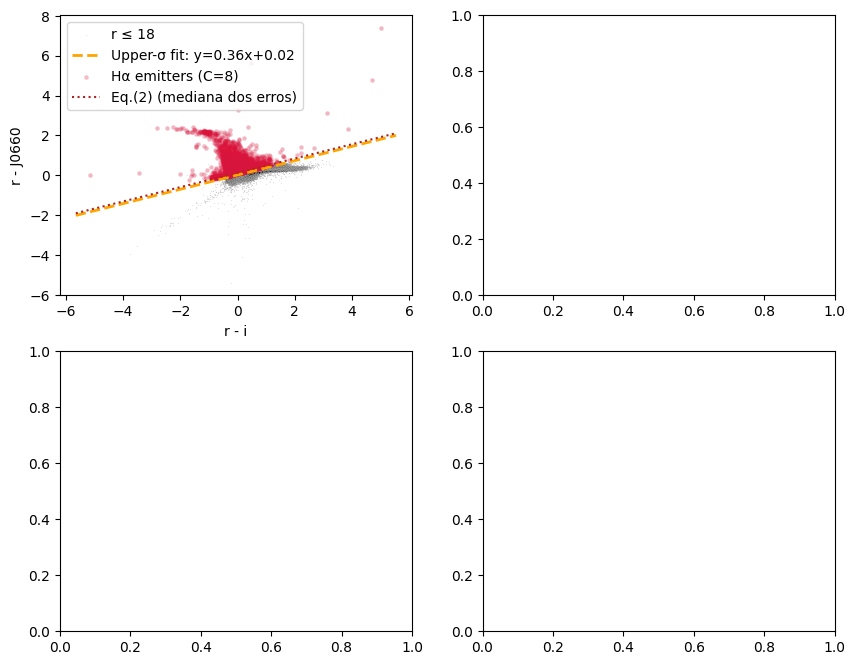

: 

In [ ]:
# ---------- Exemplo com seus 4 painéis ----------
m1 = (full['mag_psf_r'] <= 18)
m2 = (full['mag_psf_r'] > 18) & (full['mag_psf_r'] <= 19)
m3 = (full['mag_psf_r'] > 19) & (full['mag_psf_r'] <= 20)
m4 = (full['mag_psf_r'] > 20) & (full['mag_psf_r'] <= 21)

plt.figure(figsize=(10, 8))
ax1 = plt.subplot(221); ax2 = plt.subplot(222); ax3 = plt.subplot(223); ax4 = plt.subplot(224)

ax1, em1 = plot_panel_eq12(ax1, full[m1], 'r ≤ 18',   C=8.0, column_r= 'mag_psf_r', column_i='mag_psf_i', column_j='mag_psf_j0660')
ax2, em2 = plot_panel_eq12(ax2, full[m2], '18 < r ≤ 19', C=8.0, column_r= 'mag_psf_r', column_i='mag_psf_i', column_j='mag_psf_j0660')
ax3, em3 = plot_panel_eq12(ax3, full[m3], '19 < r ≤ 20', C=8.0, column_r= 'mag_psf_r', column_i='mag_psf_i', column_j='mag_psf_j0660')
ax4, em4 = plot_panel_eq12(ax4, full[m4], '20 < r ≤ 21', C=8.0, column_r= 'mag_psf_r', column_i='mag_psf_i', column_j='mag_psf_j0660')

for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlim(-0.5, 1.5)
    ax.legend()

plt.tight_layout()
plt.show()

In [12]:
df_emitters_total.to_csv('../data/halpha_emitters_mc.csv', index=False)

In [13]:
len(df_emitters_total)

65059

In [11]:
emitters = pd.read_csv('../data/halpha_emitters_mc.csv')


FileNotFoundError: [Errno 2] No such file or directory: '../data/halpha_emitters_mc.csv'

In [14]:
df_emitters_total

id         ra        dec  parallax  gaia_ruwe  \
0      b'i06MC007700926'  36.309193 -71.384071  1.815123   1.007472   
1      b'i06MC007700E49'  37.636734 -71.191864  2.918159   1.249673   
2      b'i06MC007700E6B'  38.089119 -71.189514  4.901247   1.201369   
3      b'i06MC007700GH8'  38.173389 -71.118126  3.720568   1.069893   
4      b'i06MC007700H6I'  37.326122 -71.092987       NaN        NaN   
...                  ...        ...        ...       ...        ...   
65054  b'i06MC00870EUQ7'  78.607742 -70.375298  0.768182   1.061818   
65055  b'i06MC00870EURP'  78.605652 -70.375824  0.657710   1.049445   
65056  b'i06MC00870FMS7'  78.360703 -70.306526       NaN        NaN   
65057  b'i06MC00870FS9A'  78.918091 -70.289459 -0.996678   1.047148   
65058  b'i06MC00870G2RY'  78.257347 -70.257965 -0.051976   1.123515   

       gaia_parallax_over_error  gaia_classprob_dsc_combmod_star  \
0                    187.792953                     9.998661e-01   
1                    236.691559                     9.998530e-01   
2                    399.763916                     9.998841e-01   
3                    302.439331                     9.998322e-01   
4                           NaN                     9.998220e-01   
...                         ...                              ...   
65054                  1.146835                     9.992688e-01   
65055                  1.587192                     1.030290e-07   
65056                       NaN                     9.812415e-01   
65057                 -1.057733                     2.953818e-01   
65058                 -0.112731                     9.999881e-01   

       gaia_in_qso_candidates  gaia_in_galaxy_candidates  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
65054                       0                          0   
65055                       1                          0   
65056                       0                          0   
65057                       1                          0   
65058                       0                          0   

       gaia_phot_bp_rp_excess_factor  ...  mag_psf_r  mag_psf_j0660  \
0                           1.214372  ...  12.217219      12.033581   
1                           1.202481  ...  12.615238      12.534400   
2                           1.225760  ...  12.586771      12.502151   
3                           1.200778  ...  12.304805      12.133010   
4                           1.980481  ...  12.218663      11.943160   
...                              ...  ...        ...            ...   
65054                       0.792767  ...  20.860634      18.407490   
65055                       1.319424  ...  20.068811      19.107918   
65056                       1.773778  ...  20.769709      19.035252   
65057                       1.398124  ...  20.553350      18.975359   
65058                       1.349242  ...  20.000917      18.615147   

       mag_psf_i  mag_psf_j0861  mag_psf_z        ri    rJ0660  delta_Ha  \
0      12.002780      11.734583        NaN  0.214439  0.183639  0.089611   
1      12.478921      12.436558  12.409357  0.136317  0.080838  0.014727   
2      12.437570      12.246639  12.202872  0.149201  0.084620  0.013905   
3      12.238482      11.870986  11.996332  0.066323  0.171795  0.130696   
4      12.184551      11.607293  11.835857  0.034112  0.275503  0.245915   
...          ...            ...        ...       ...       ...       ...   
65054  20.534914      20.305983  20.773535  0.325720  2.453144  2.233799   
65055  20.063478      20.315496  20.446209  0.005333  0.960894  0.861137   
65056  20.609018      20.548590  20.779205  0.160690  1.734457  1.576712   
65057  20.459166  

In [43]:
from astroquery.xmatch import XMatch
import io
import astropy.units as u

table = XMatch.query(
    cat1=open('/home/shared/splus_gaia/data/halpha_emitters-gustabin/MC.csv'),
    cat2='simbad',
    max_distance=2* u.arcsec,
    colRA1='ra',
    colDec1='dec'
)

Could not import regions, which is required for some of the functionalities of this module.


In [44]:
tb = table.to_pandas()

In [47]:
len(table)

6818

In [45]:
tb.to_csv('/home/shared/splus_gaia/data/halpha_emitters-gustabin/MC_simbad.csv', index=False)

In [17]:
tb.columns

Index(['angDist', 'id', 'ra', 'dec', 'parallax', 'err_mag_pstotal_r',
       'err_mag_pstotal_i', 'err_mag_pstotal_j0660', 'gaia_ruwe',
       'gaia_parallax_over_error', 'gaia_classprob_dsc_combmod_star',
       'gaia_in_qso_candidates', 'gaia_in_galaxy_candidates',
       'gaia_phot_bp_rp_excess_factor', 'mag_pstotal_r', 'mag_pstotal_i',
       'mag_pstotal_j0660', 'main_id', 'ra2', 'dec2', 'coo_err_maj',
       'coo_err_min', 'coo_err_angle', 'otype', 'nbref', 'ra_sexa', 'dec_sexa',
       'coo_qual', 'coo_bibcode', 'main_type', 'other_types', 'radvel',
       'radvel_err', 'redshift', 'redshift_err', 'sp_type', 'morph_type',
       'plx', 'plx_err', 'pmra', 'pmdec', 'pm_err_maj', 'pm_err_min',
       'pm_err_pa', 'size_maj', 'size_min', 'size_angle', 'B', 'V', 'R', 'J',
       'H', 'K', 'u', 'g', 'r', 'i', 'z'],
      dtype='object')

In [46]:
tb.groupby('main_type').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

main_type  counts
66                  Star    1464
24               EmLine*    1276
56               RRLyrae     934
22                EclBin     632
48          PlanetaryNeb     305
..                   ...     ...
35              HighVel*       1
69  Supergiant_Candidate       1
17                   ClG       1
40                 Maser       1
54                  RGB*       1

[90 rows x 2 columns]

In [21]:
galaxies = tb[tb['otype'] == 'G']

In [20]:
galaxies.to_csv('../data/halpha_emitters_galaxies.csv', index=False)

In [21]:
binaries = tb[tb['main_type'].isin(['EclBin', 'EclBin_Candidate'])]

In [22]:
binaries.to_csv('../data/halpha_emitters_binaries.csv', index=False)

# Checking methods

In [137]:
g = pd.read_csv('/home/shared/splus_gaia/data/halpha_emitters-gustabin/MC.csv')
m = pd.read_csv('/home/shared/splus_gaia/data/h-alpha-selection-marina/MC/halpha_emitters_mc.csv')

print(f'Gustavo: {len(g)} emissores', f'Marina: {len(m)} emissores')

Gustavo: 132081 emissores Marina: 65059 emissores


In [138]:
g = g[(g['err_mag_psf_j0660'] < 0.2)&
        (g['err_mag_psf_i'] < 0.2)&
        (g['err_mag_psf_r'] < 0.2)&
        (g['mag_psf_j0660']/g['err_mag_psf_j0660'] > 10)&
        (g['mag_psf_i']/g['err_mag_psf_i'] > 10)&
        (g['mag_psf_r']/g['err_mag_psf_r'] > 10)&
        (g['gaia_ruwe'] < 1.4)]

In [139]:
m = m[m['gaia_ruwe'] < 1.4]

In [140]:
print(f'Gustavo: {len(g)} emissores', f'Marina: {len(m)} emissores')

Gustavo: 103045 emissores Marina: 55765 emissores


In [141]:
match = pd.merge(g, m, how='inner', on=['id'], suffixes=('_g', '_m'))

In [157]:
len(match)

33476

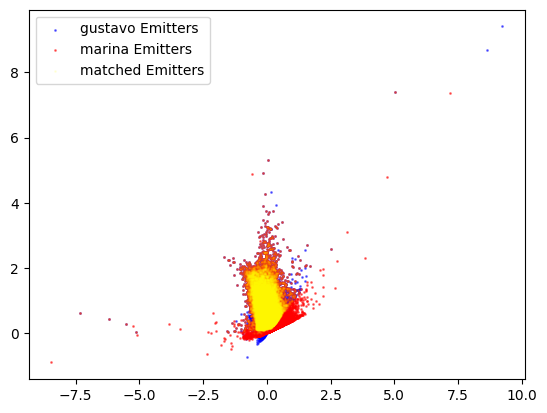

In [143]:
plt.scatter(g['mag_psf_r'] - g['mag_psf_i'], g['mag_psf_r'] - g['mag_psf_j0660'], s=1, color='blue', alpha=0.5, label='gustavo Emitters')
plt.scatter(m['mag_psf_r'] - m['mag_psf_i'], m['mag_psf_r'] - m['mag_psf_j0660'], s=1, color='red', alpha=0.5, label='marina Emitters')
plt.scatter(match['mag_psf_r_g'] - match['mag_psf_i_g'], match['mag_psf_r_g'] - match['mag_psf_j0660_g'], s=1, color='yellow', alpha=0.1, label='matched Emitters')
plt.legend()

In [146]:
g['excess'] = (g["mag_psf_r"] + g["mag_psf_i"]) / 2 - g["mag_psf_j0660"]
g_ex = g[g['excess'] >=  0.2]

In [147]:
len(g_ex)

89441

In [148]:
m['excess'] = (m["mag_psf_r"] + m["mag_psf_i"]) / 2 - m["mag_psf_j0660"]
m_ex = m[m['excess'] >=  0.2]

In [149]:
len(m_ex)

39121

In [ ]:
match['excess'] = (match["mag_psf_r_g"] + match["mag_psf_i_g"]) / 2 - match["mag_psf_j0660_g"]


In [162]:
match_ex = match[match['excess'] >=  0.2]
print(len(match), len(match_ex))

33476 32452


In [150]:
simbad = pd.read_csv('/home/shared/splus_gaia/data/h-alpha-selection-marina/MC/halpha_emitters_mc_simbad.csv')

In [151]:
m = pd.merge(m, simbad[['id', 'main_id', 'main_type']], how='left', on='id')

In [152]:
emissm = m[m['main_type'] == 'EmLine*']

emissm['excess'].describe()

count    1635.000000
mean        0.326811
std         0.185591
min        -0.031648
25%         0.234210
50%         0.311046
75%         0.378079
max         3.186092
Name: excess, dtype: float64

In [154]:
sg = pd.read_csv('/home/shared/splus_gaia/data/halpha_emitters-gustabin/MC_simbad.csv')

In [156]:
emissg = sg[sg['main_type'] == 'EmLine*']


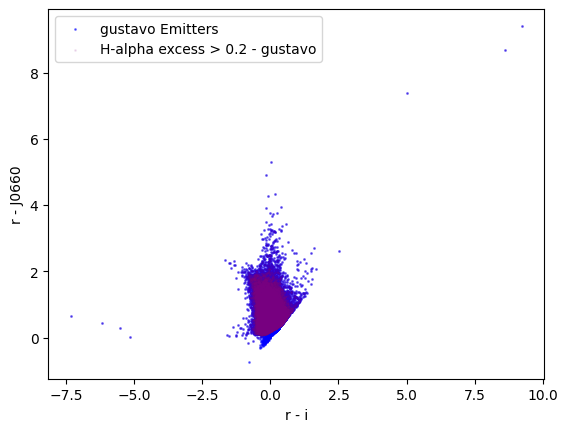

In [165]:
plt.scatter(g['mag_psf_r'] - g['mag_psf_i'], g['mag_psf_r'] - g['mag_psf_j0660'], s=1, color='blue', alpha=0.5, label='gustavo Emitters')
plt.scatter(g_ex['mag_psf_r'] - g_ex['mag_psf_i'], g_ex['mag_psf_r'] - g_ex['mag_psf_j0660'], s=1, color='purple', alpha=0.1, label='H-alpha excess > 0.2 - gustavo')


# plt.scatter(m['mag_psf_r'] - m['mag_psf_i'], m['mag_psf_r'] - m['mag_psf_j0660'], s=1, color='red', alpha=0.1, label='marina Emitters')
# plt.scatter(m_ex['mag_psf_r'] - m_ex['mag_psf_i'], m_ex['mag_psf_r'] - m_ex['mag_psf_j0660'], s=1, color='purple', alpha=0.1, label='H-alpha excess > 0.2')

# plt.scatter(match['mag_psf_r_g'] - match['mag_psf_i_g'], match['mag_psf_r_g'] - match['mag_psf_j0660_g'], s=1, color='yellow', alpha=0.5, label='matched Emitters')

plt.legend()
plt.xlabel('r - i')
plt.ylabel('r - J0660')
plt.show()

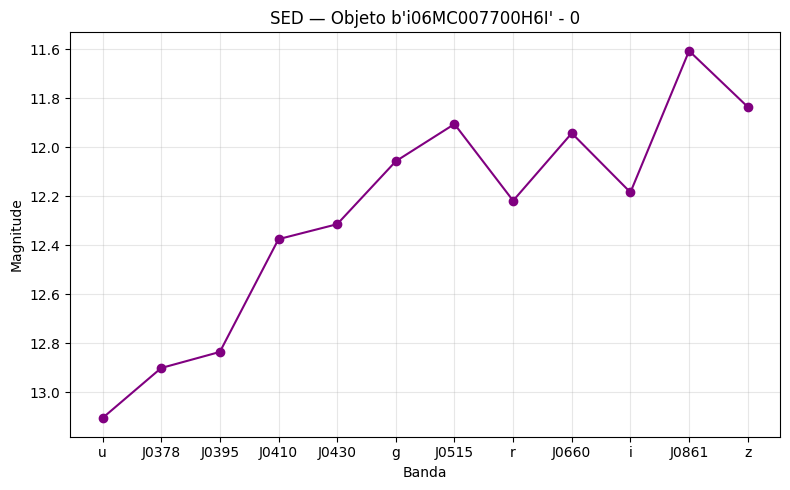

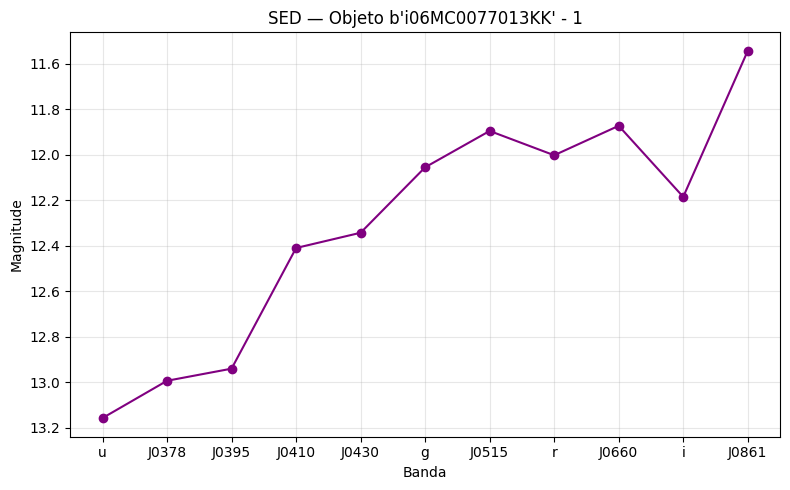

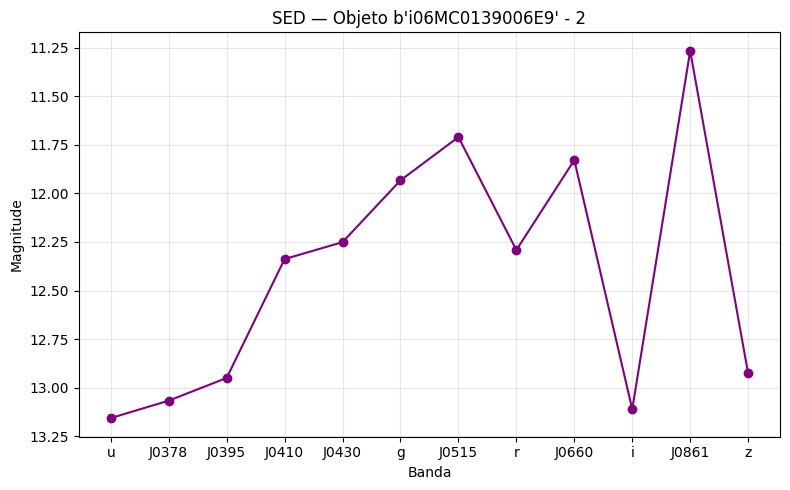

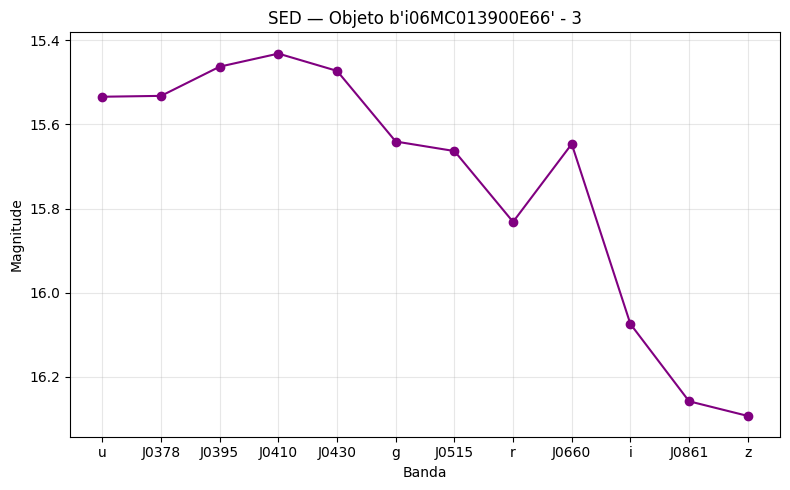

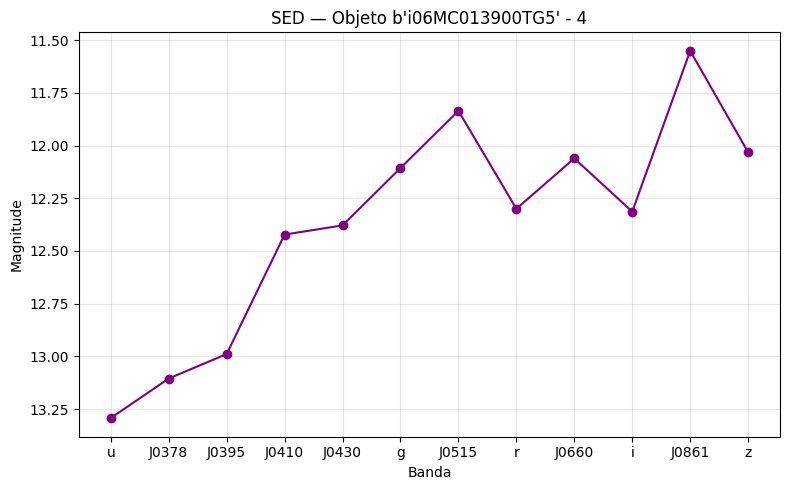

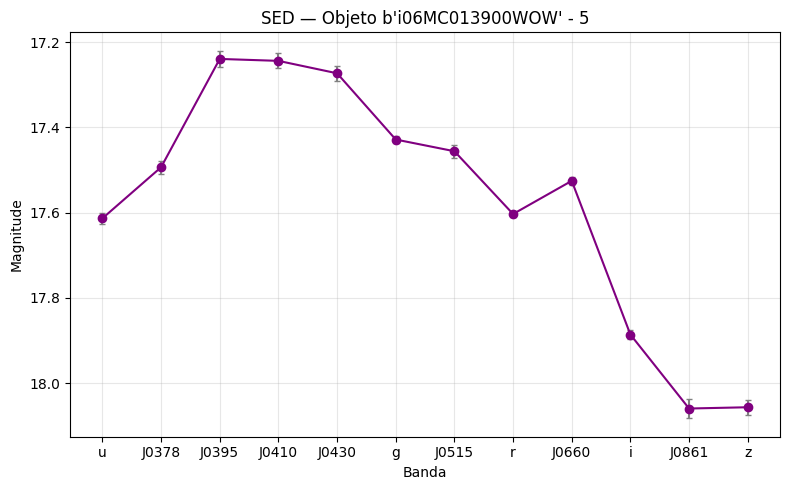

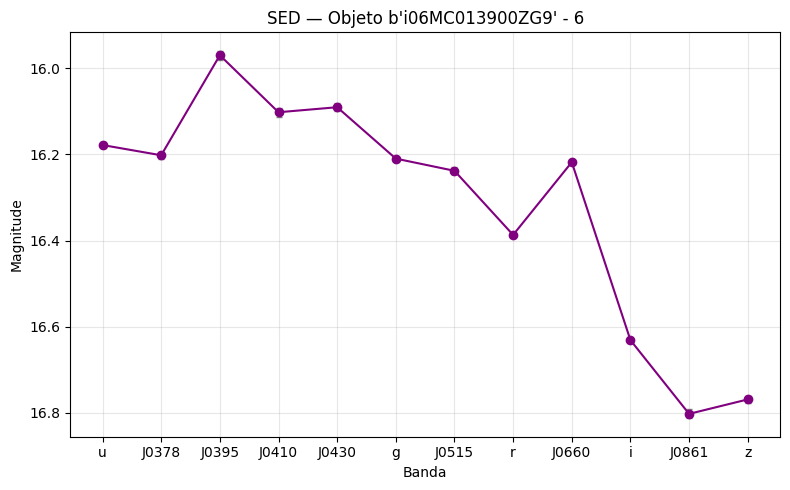

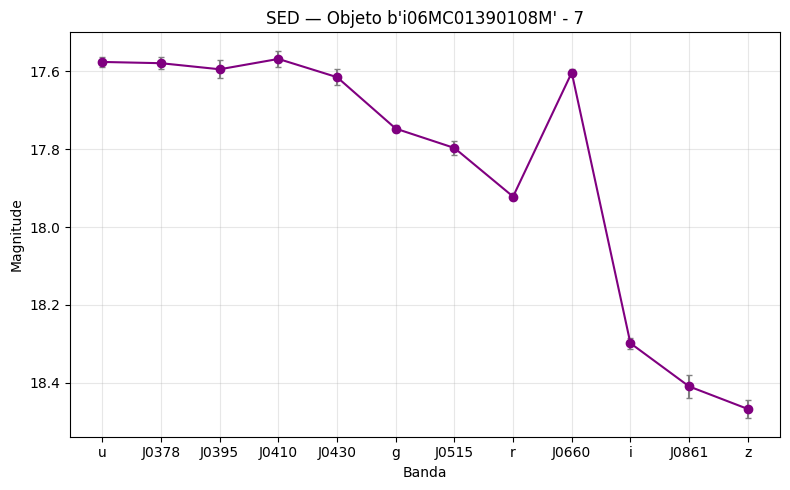

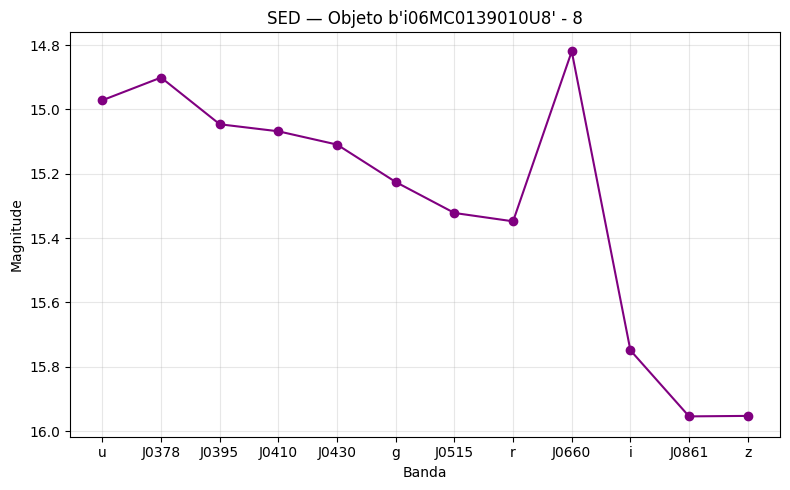

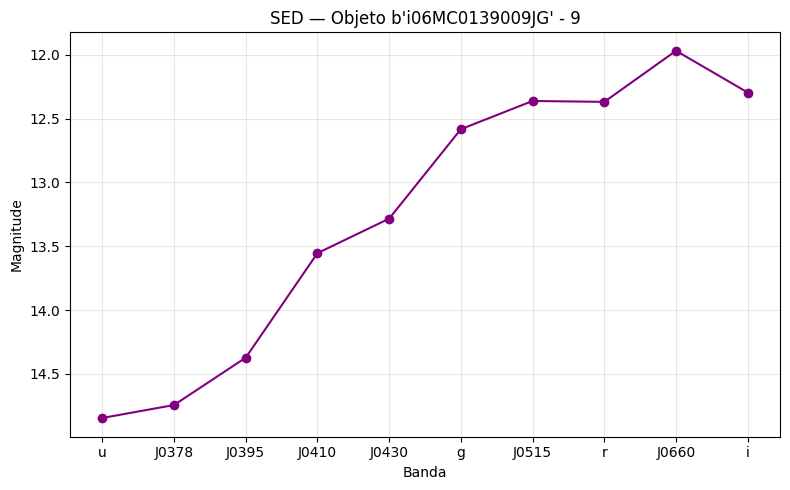

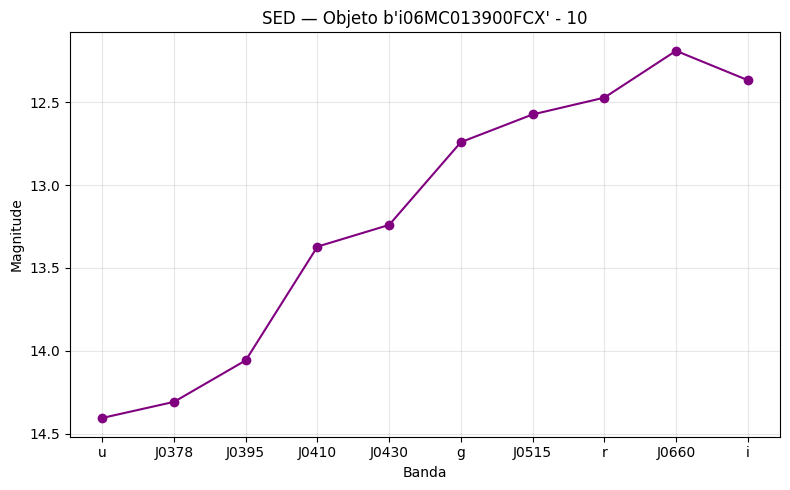

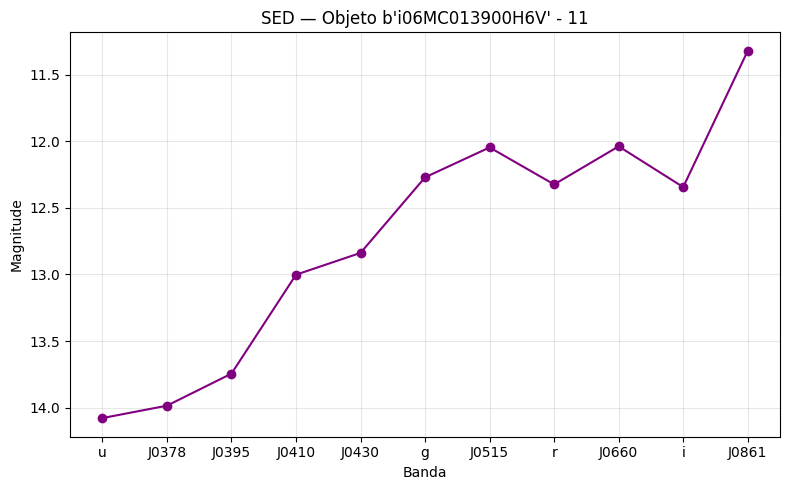

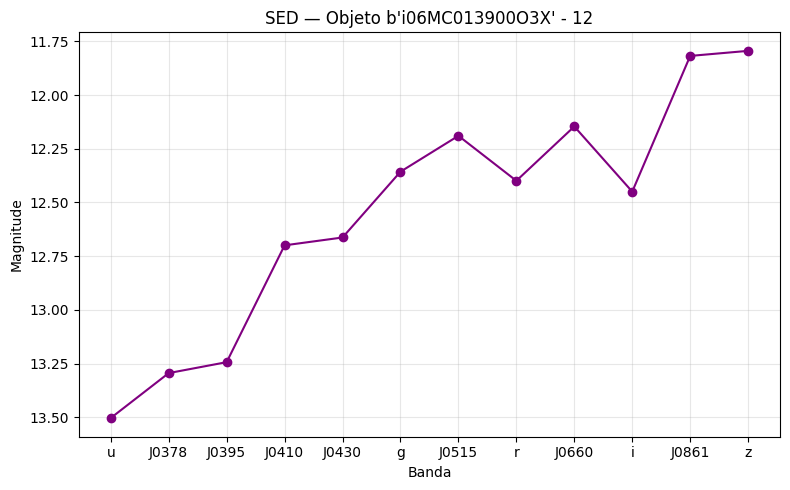

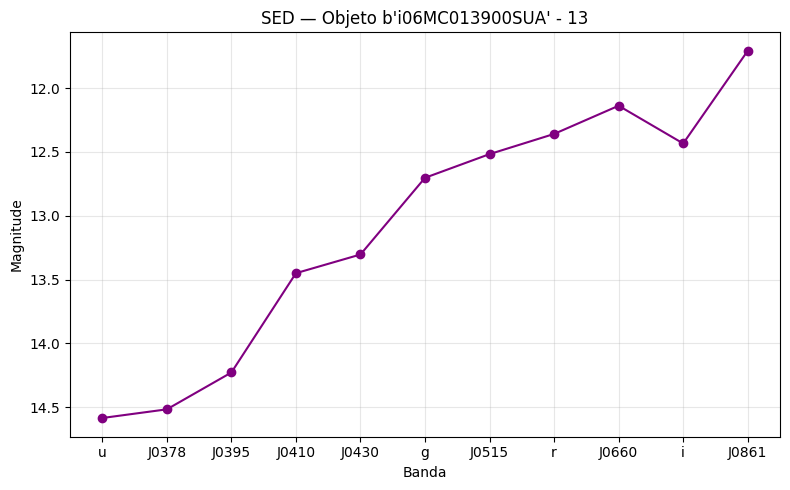

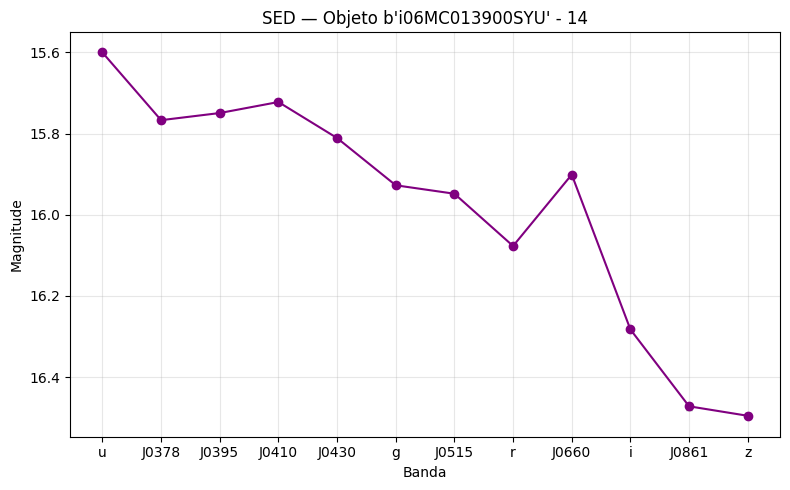

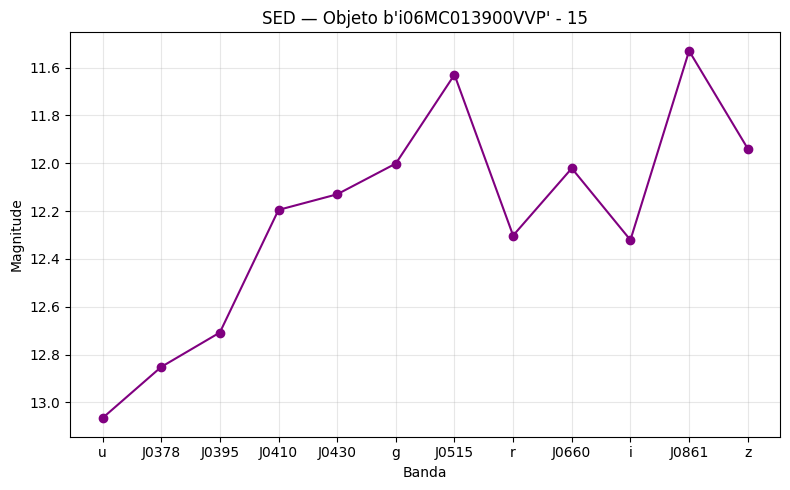

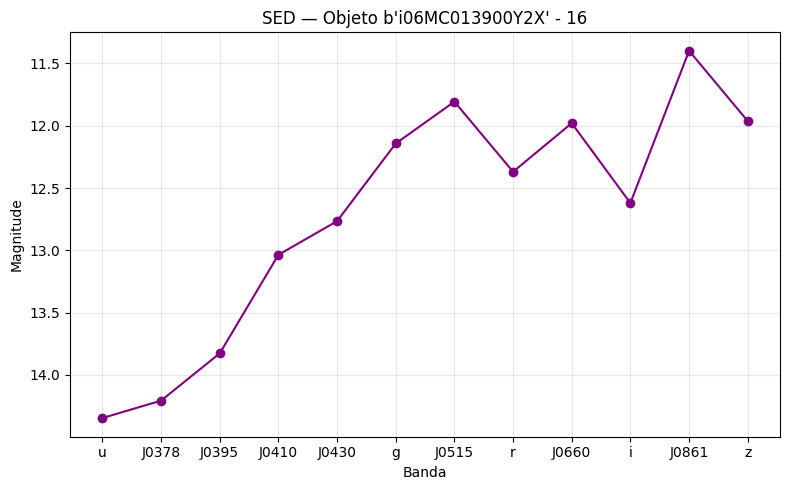

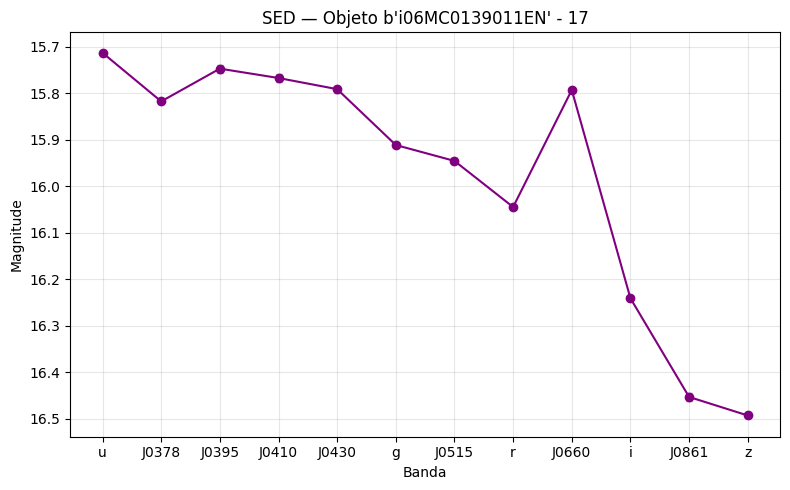

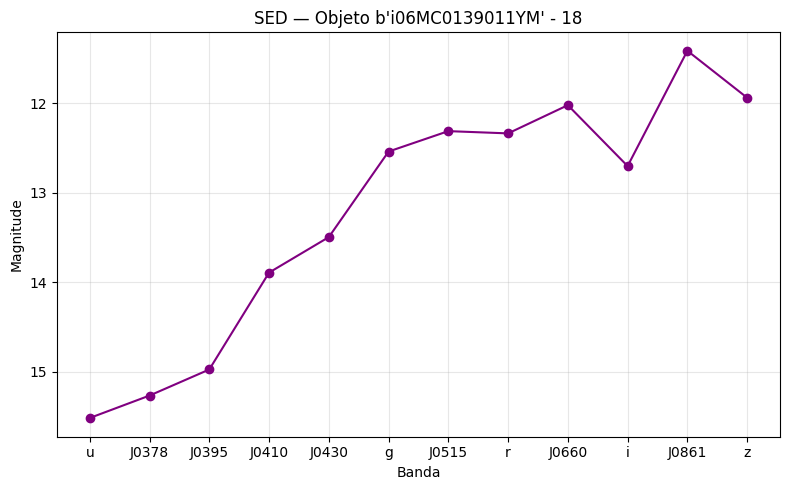

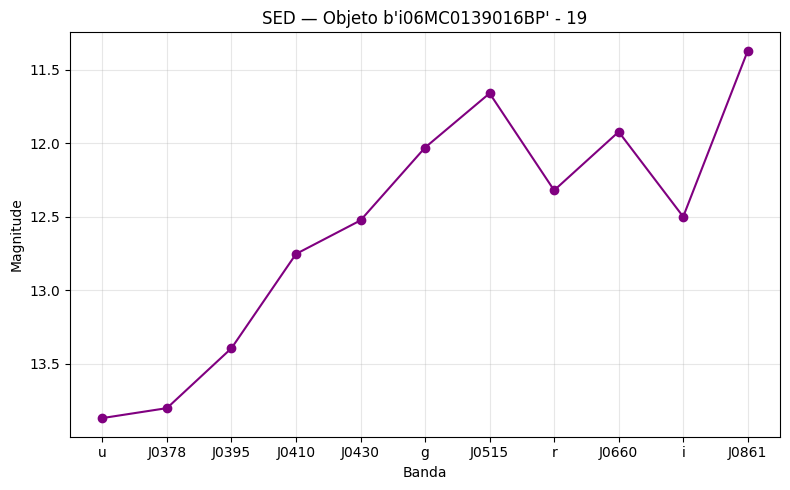

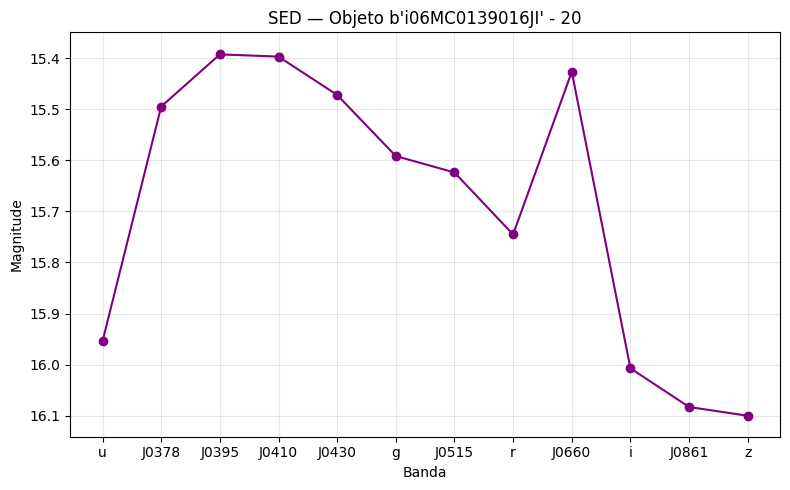

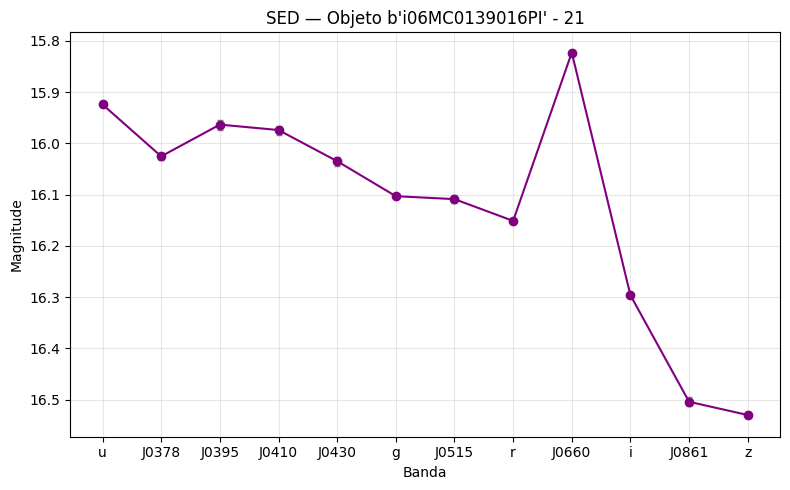

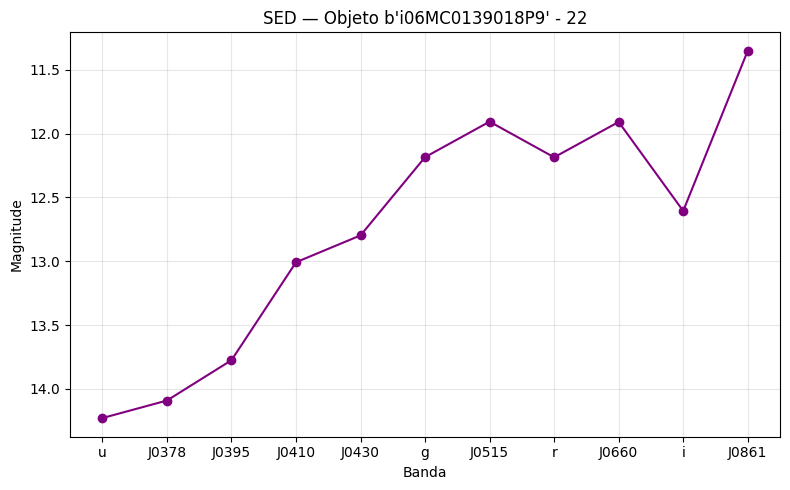

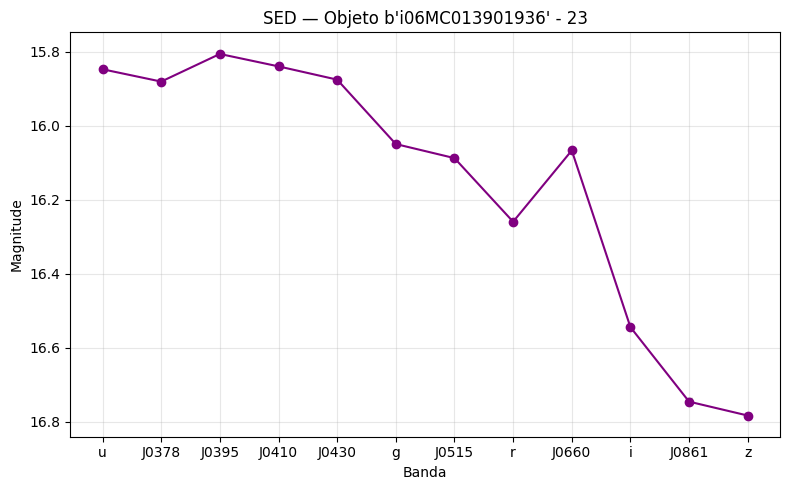

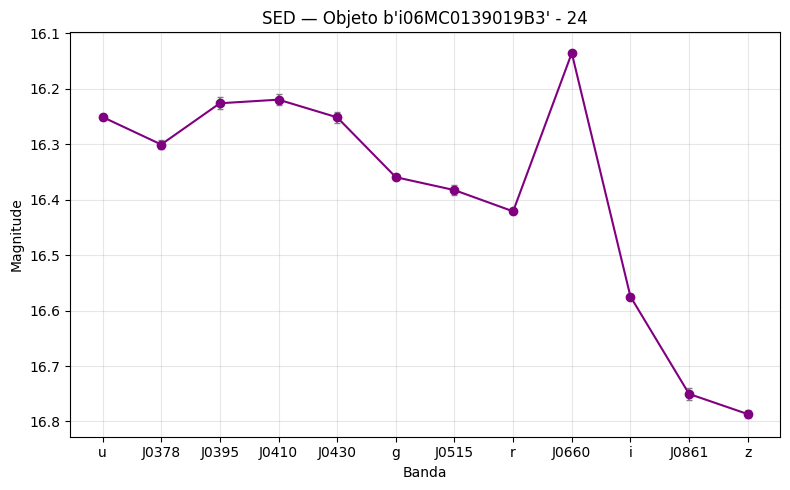

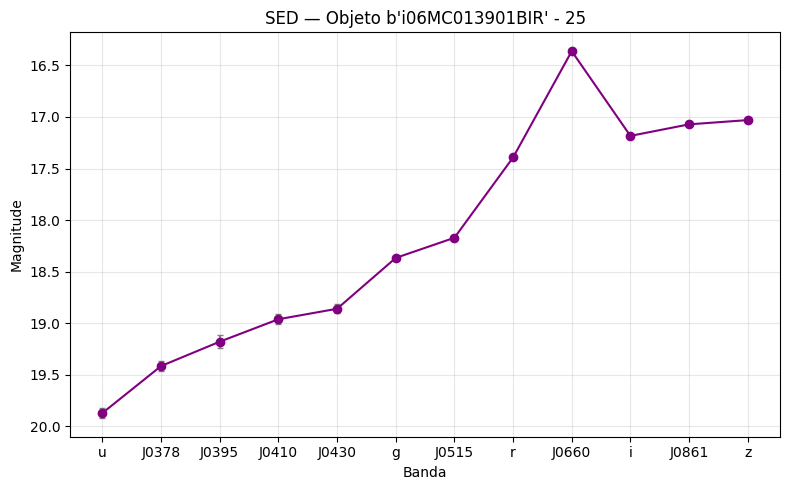

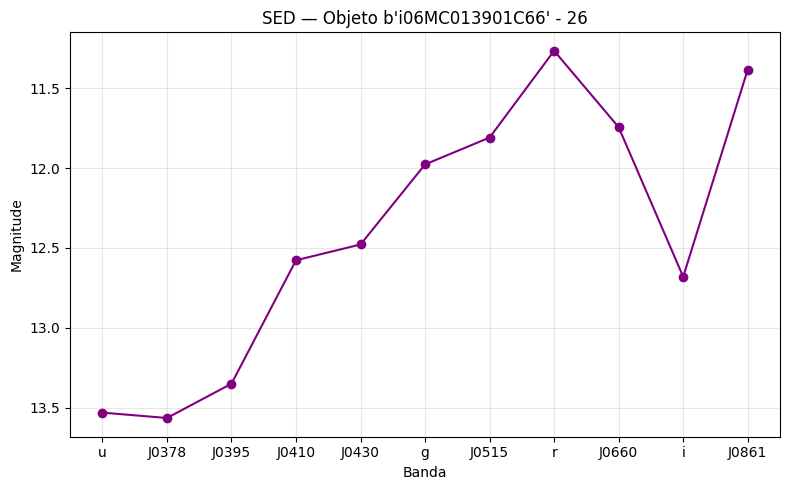

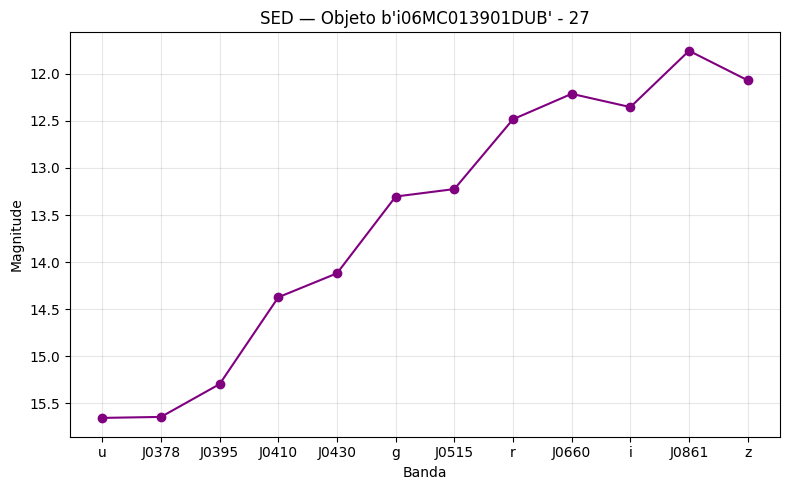

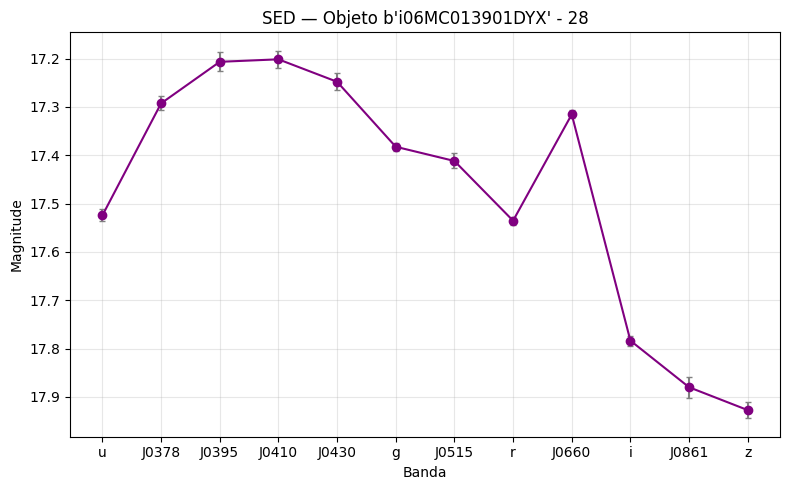

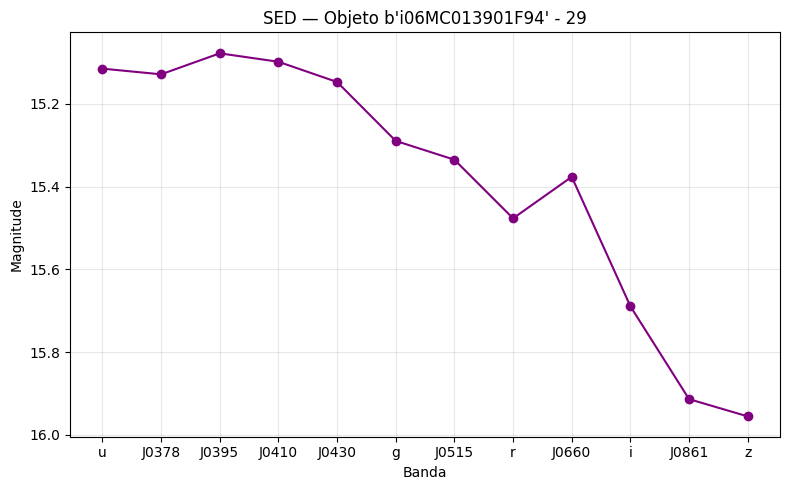

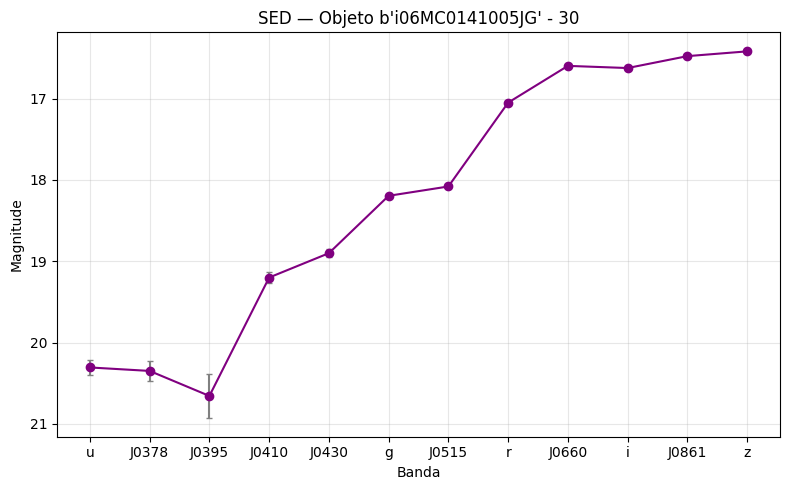

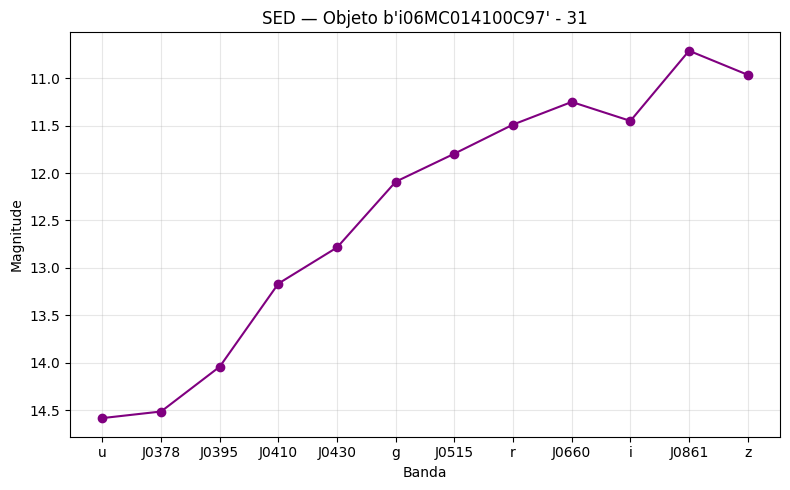

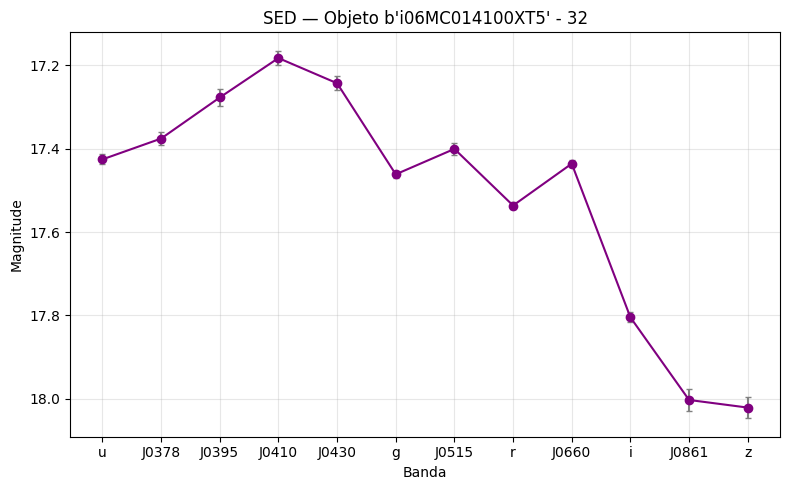

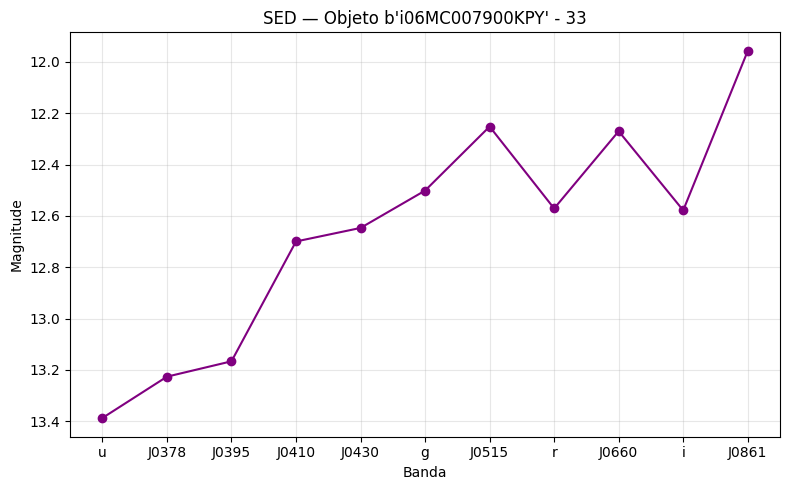

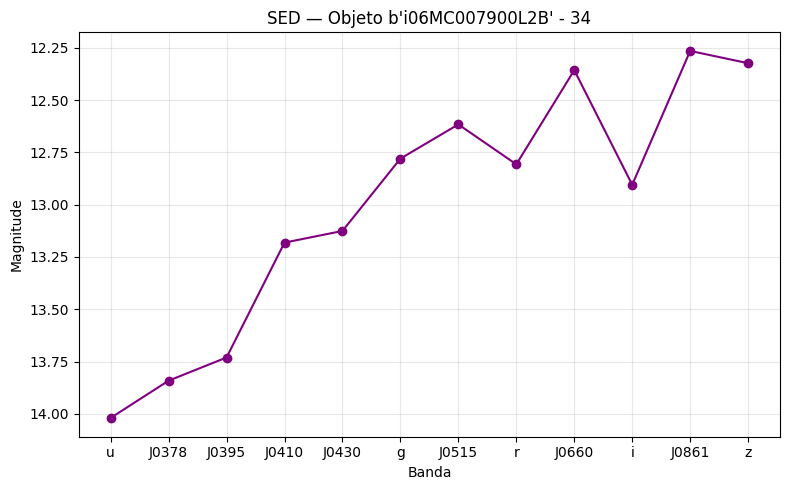

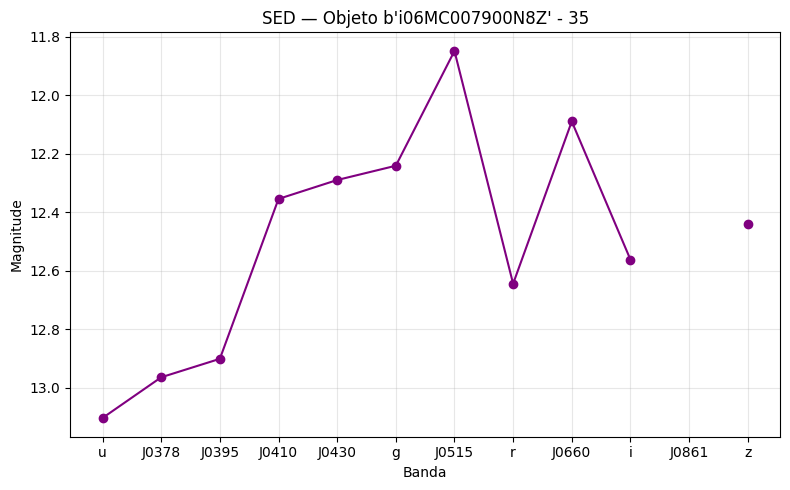

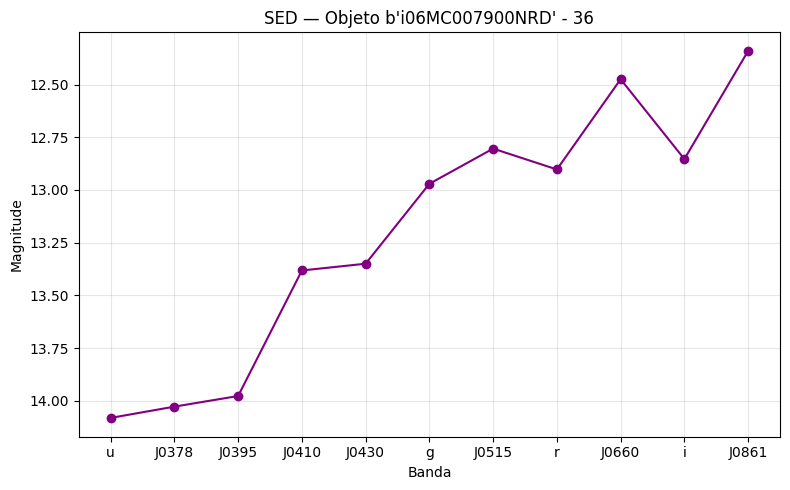

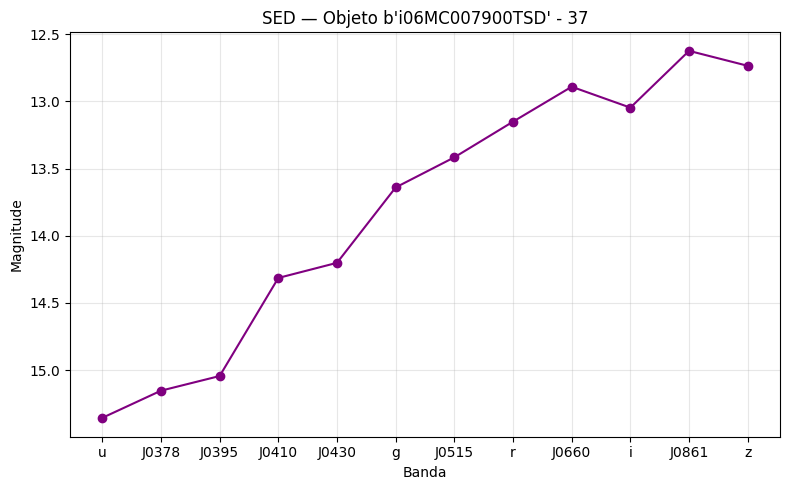

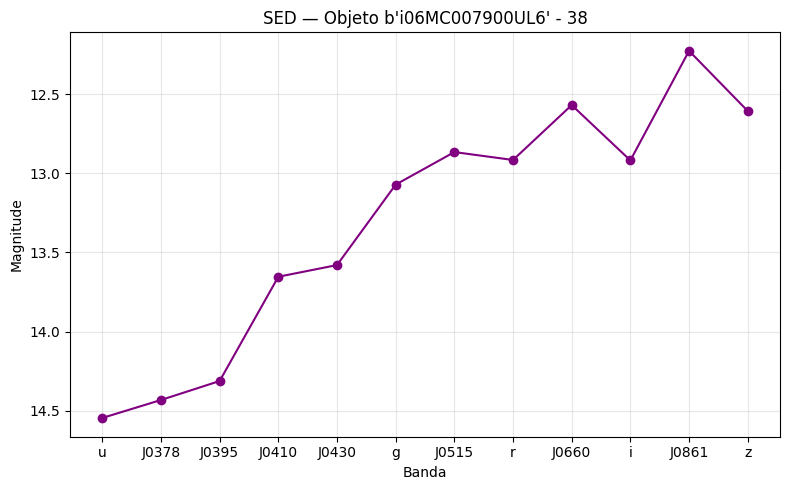

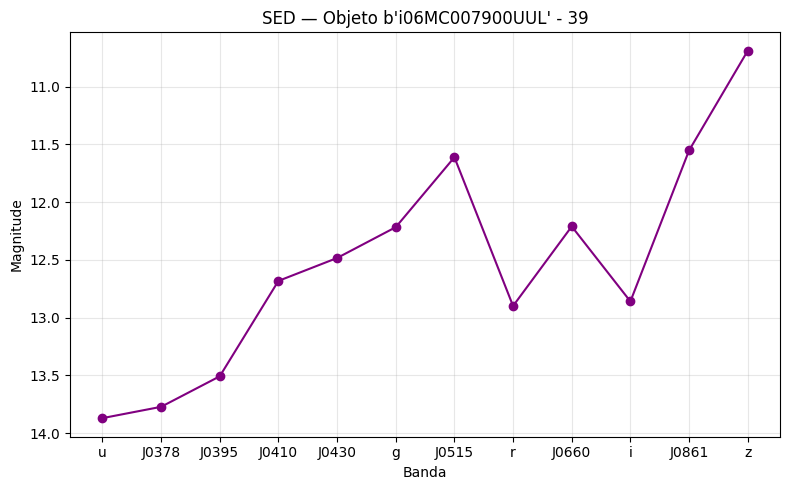

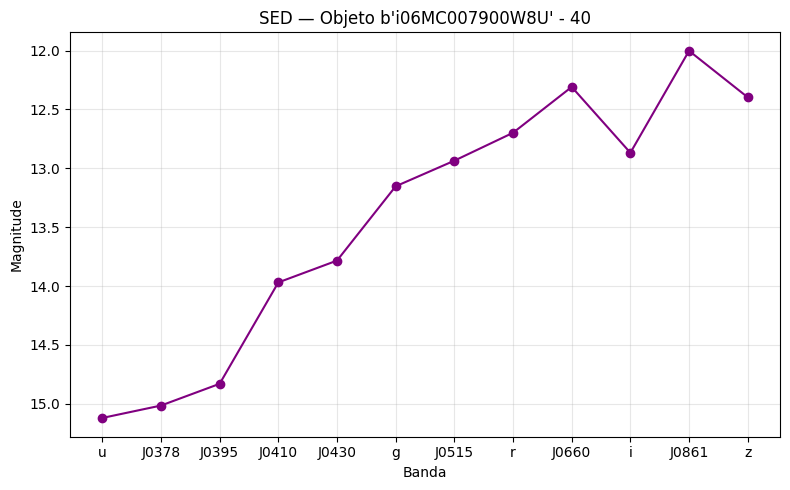

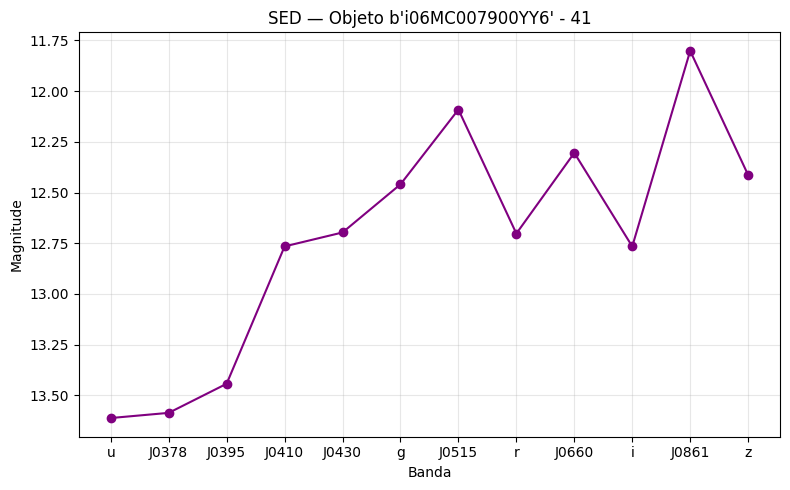

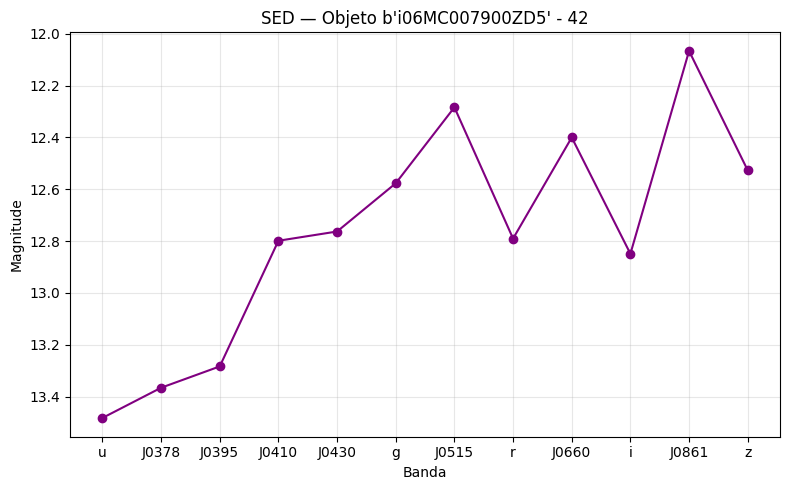

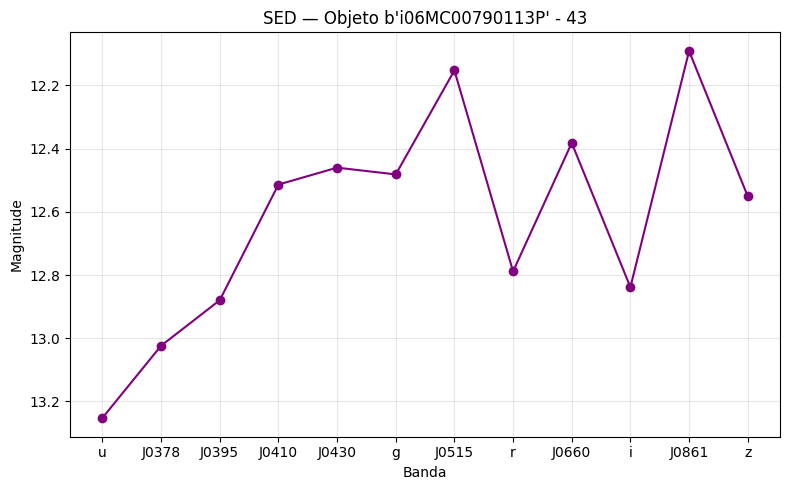

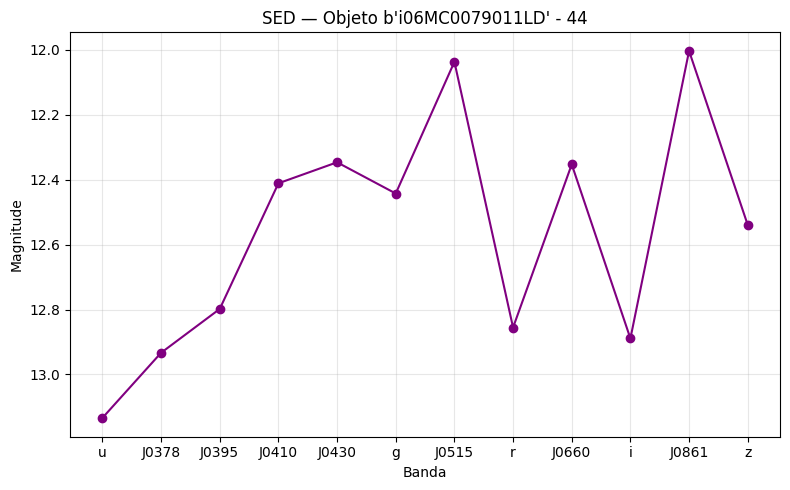

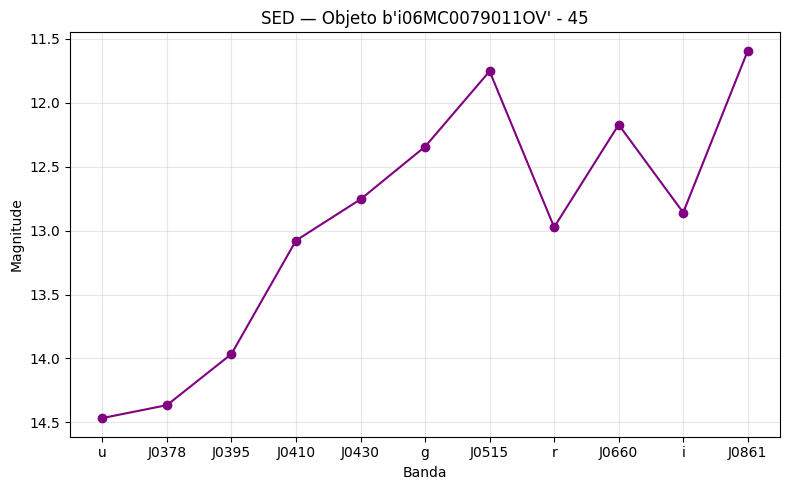

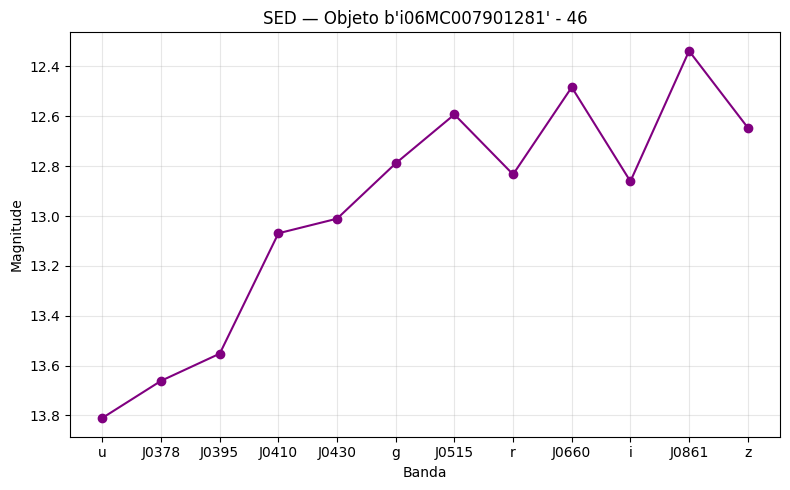

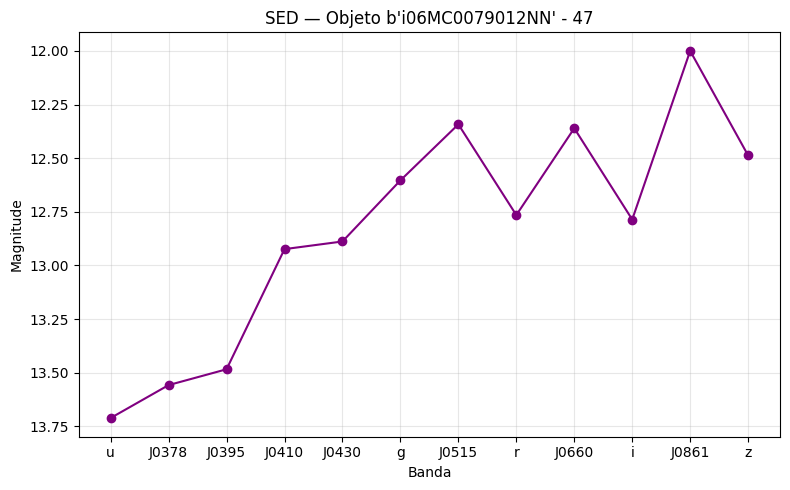

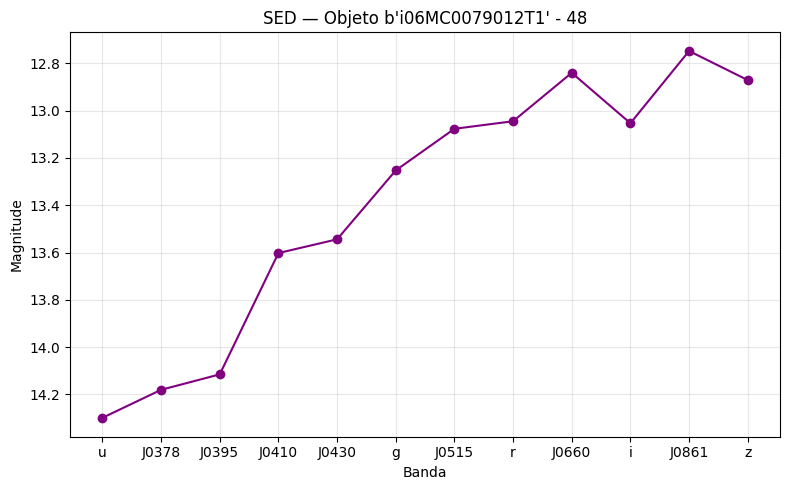

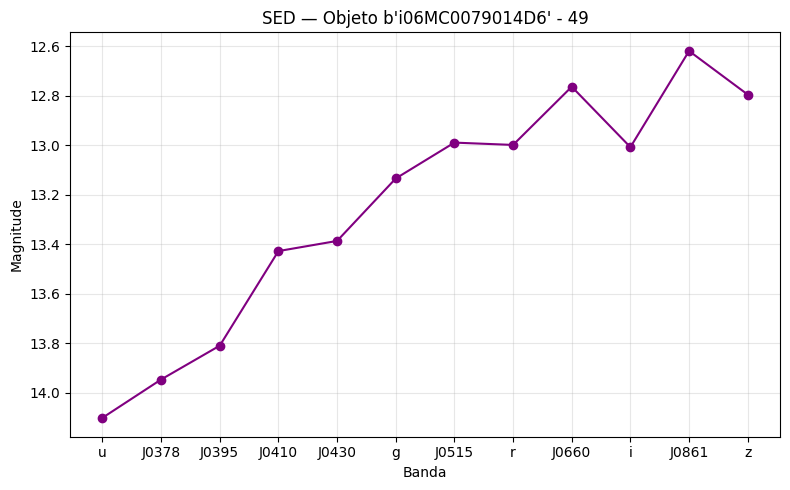

In [19]:
import numpy as np
import matplotlib.pyplot as plt

bands = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']
wavelengths = np.array([3536, 3770, 3940, 4094, 4292, 4751, 5133, 6258, 6614, 7690, 8611, 8831])

mag_cols = [f"mag_psf_{b.lower()}" for b in bands]
err_cols = [f"err_mag_psf_{b.lower()}" for b in bands]
has_errors = all(col in m_ex.columns for col in err_cols)

i = 0
for idx, row in m_ex.iterrows():
    mags = row[mag_cols].to_numpy()

    plt.figure(figsize=(8, 5))
    if has_errors:
        errs = row[err_cols].to_numpy()
        plt.errorbar(bands, mags, yerr=errs, fmt='o-', color='purple', ecolor='gray', capsize=2)
    else:
        plt.plot(bands, mags, 'o-', color='purple')

    plt.gca().invert_yaxis()
    plt.xlabel('Banda')
    plt.ylabel('Magnitude')
    plt.title(f'SED — Objeto {row["id"]} - {i}')  # <<< usar a linha atual
    # plt.title(f'SED — Objeto {row['id']} - {row['main_type']}')  # se quiser incluir o tipo

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    i += 1
    if i >= 50:
        break

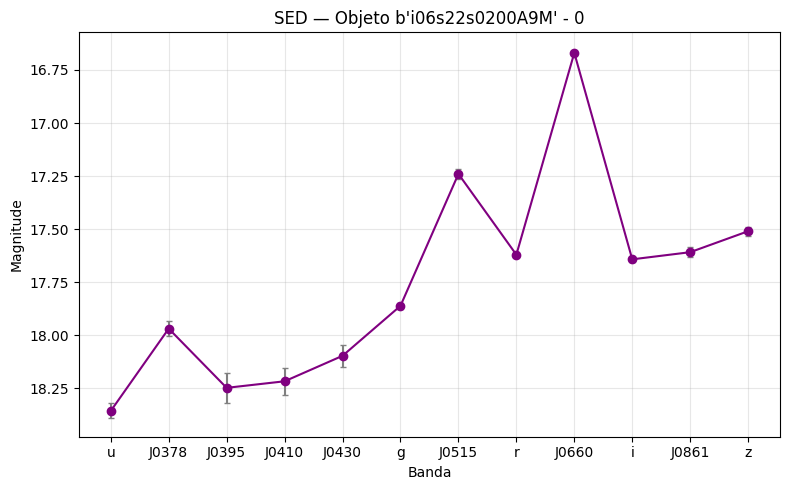

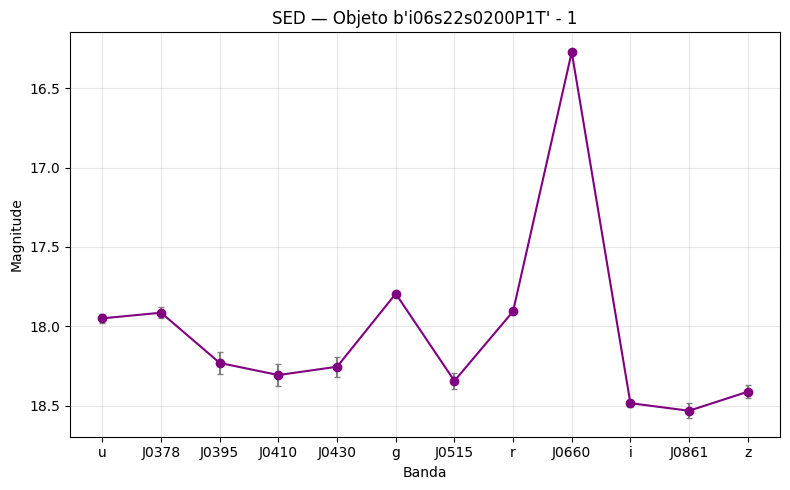

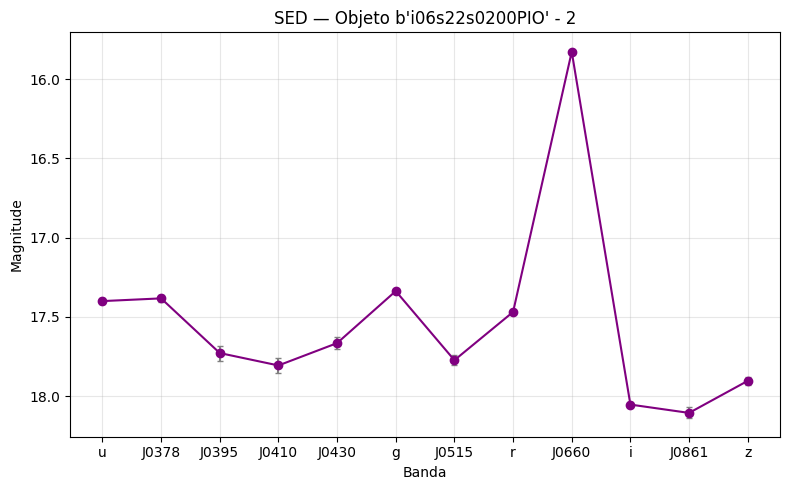

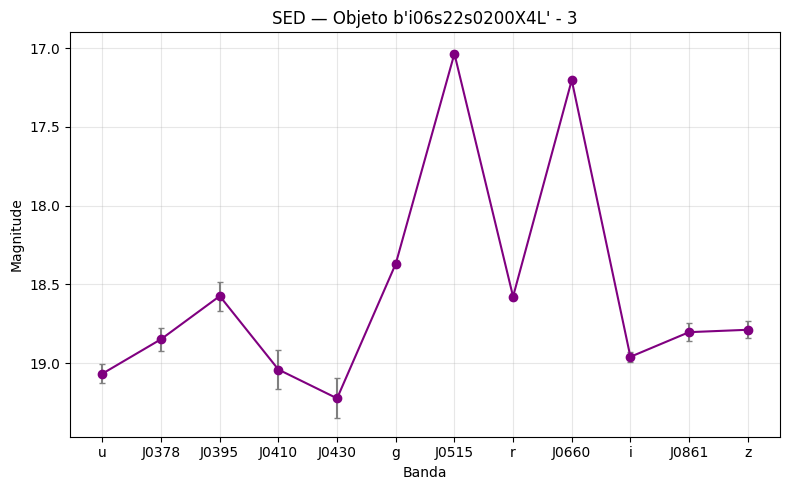

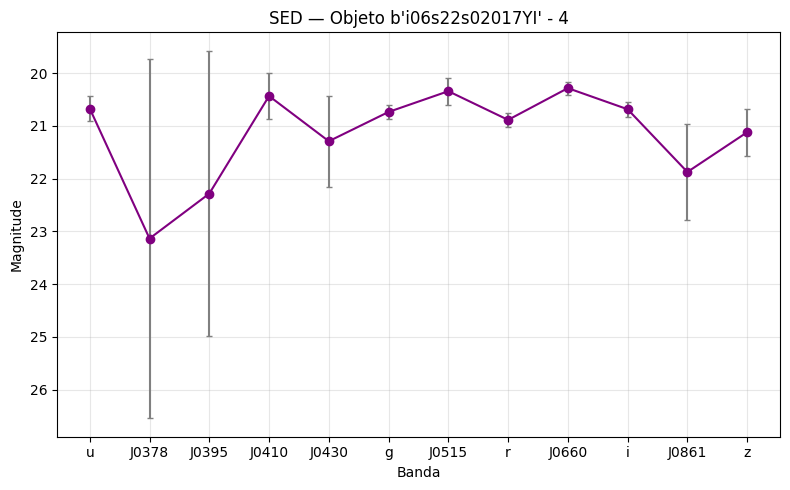

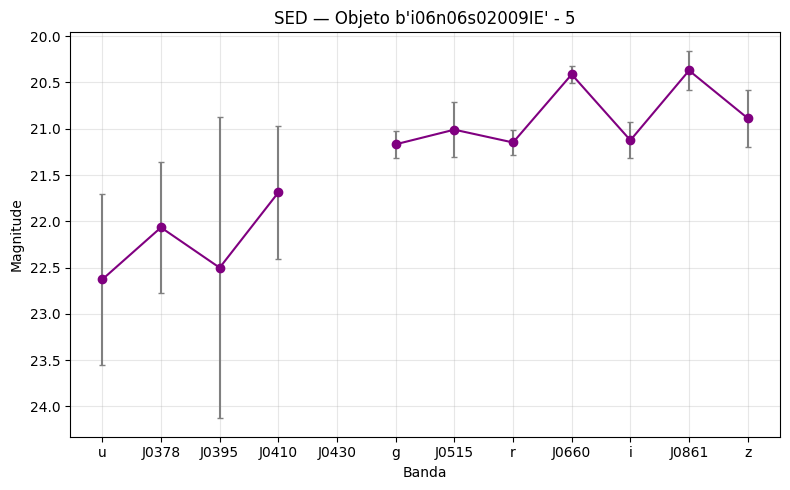

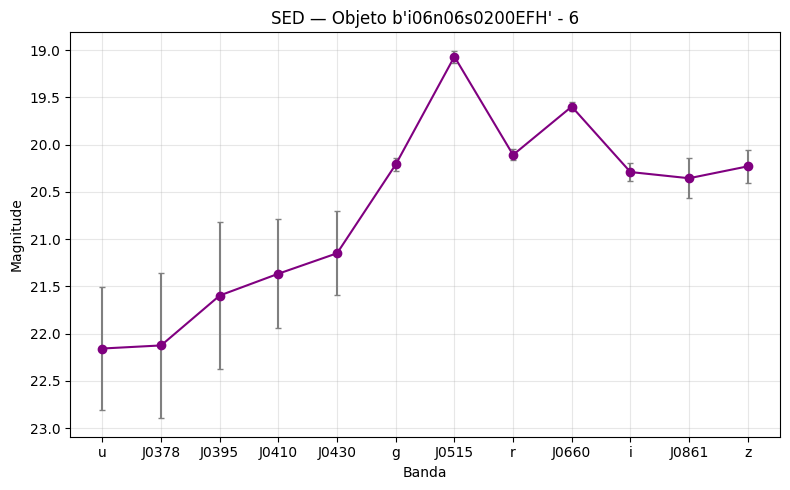

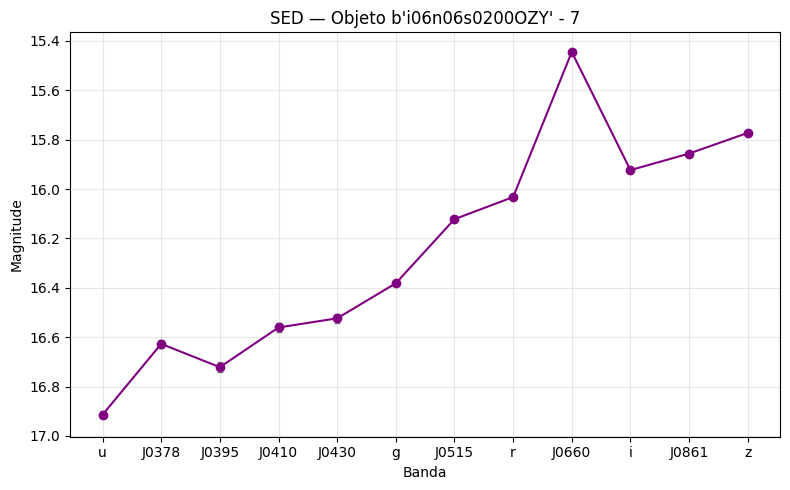

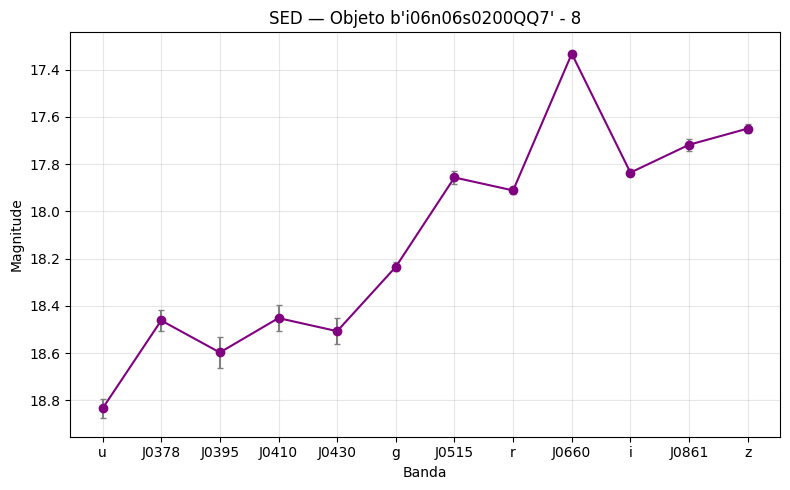

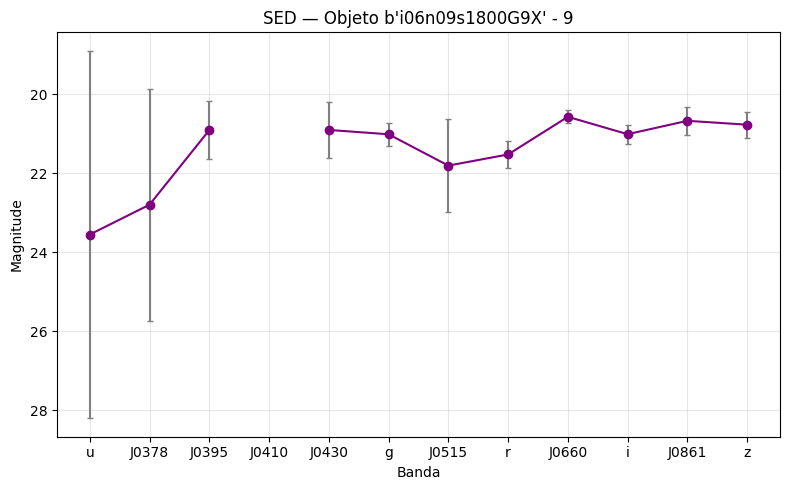

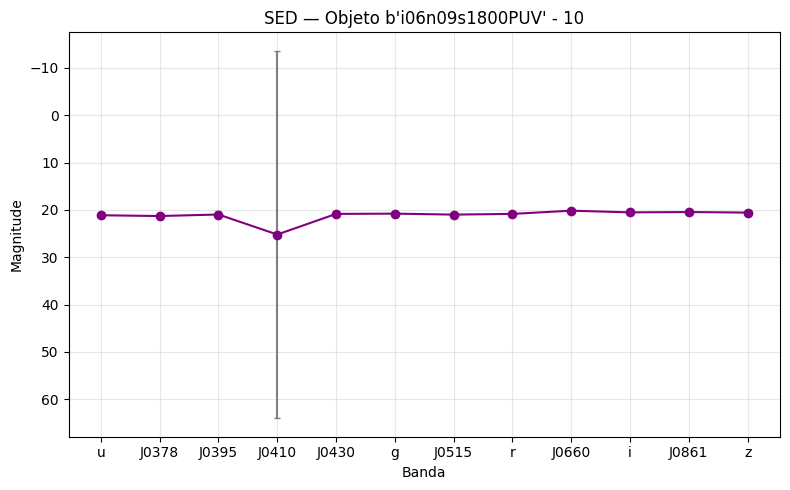

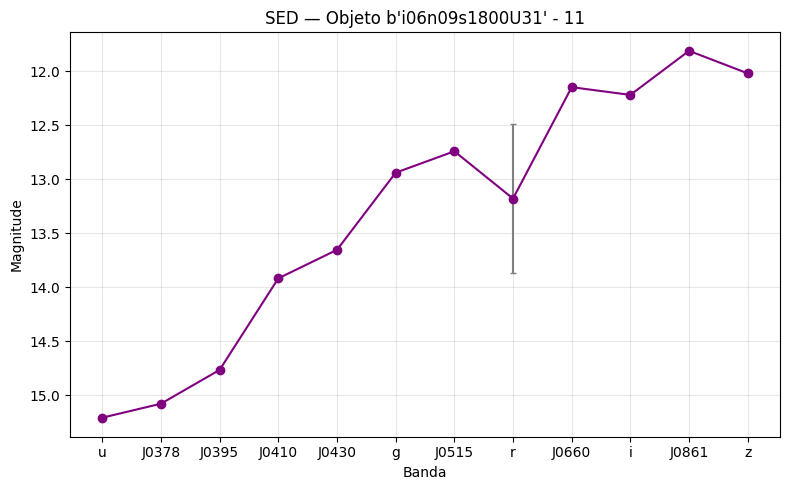

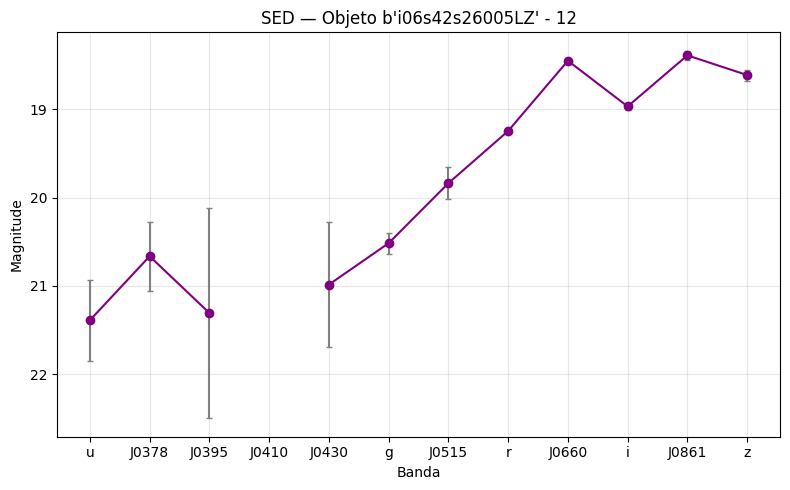

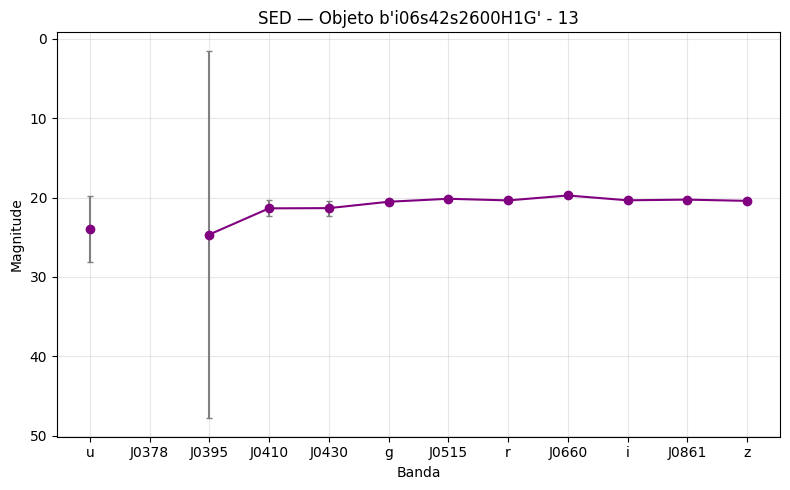

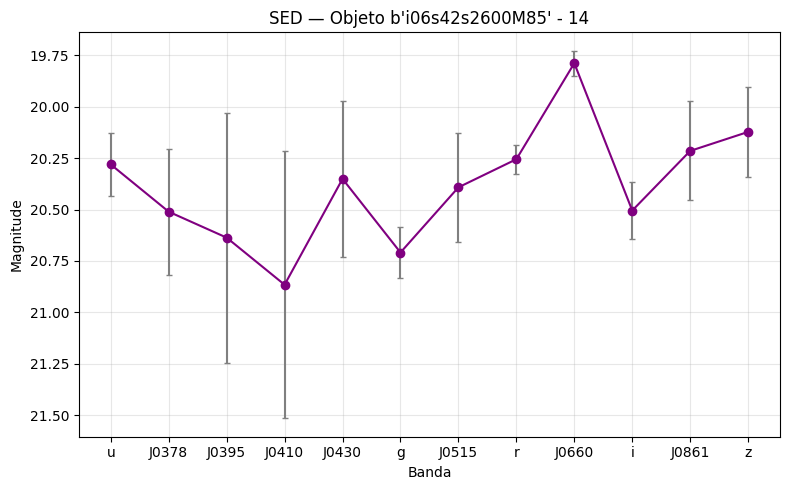

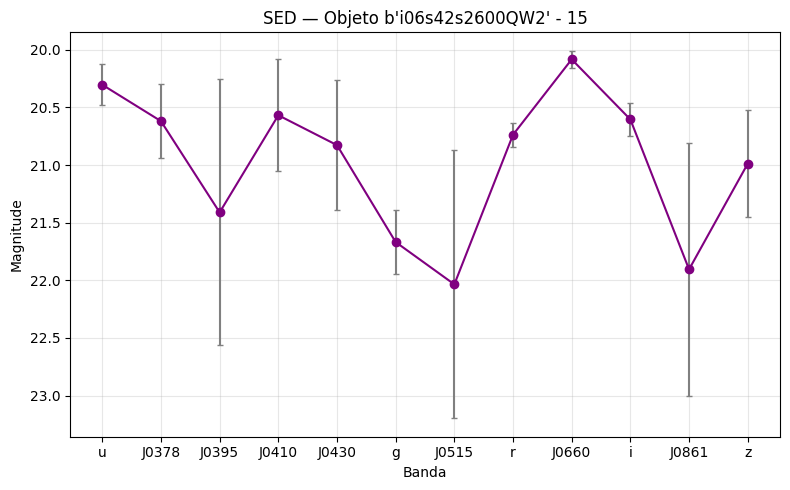

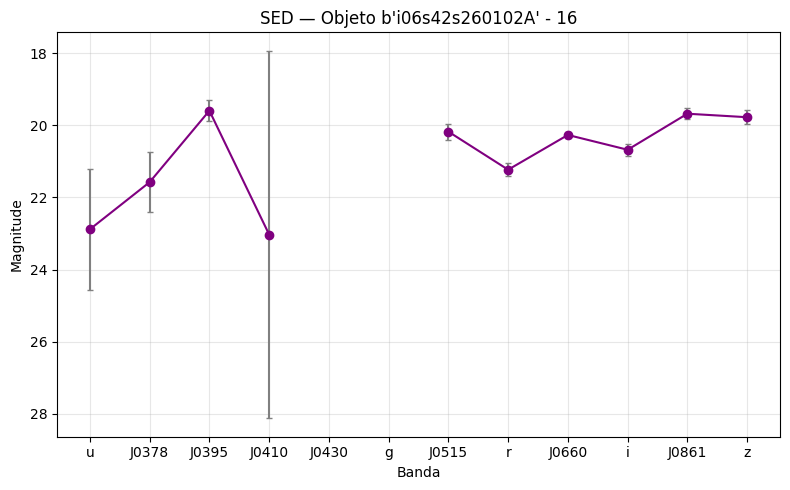

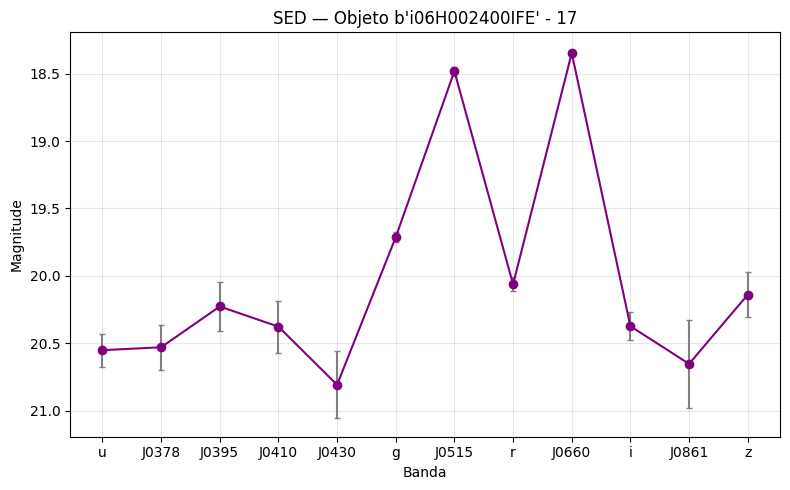

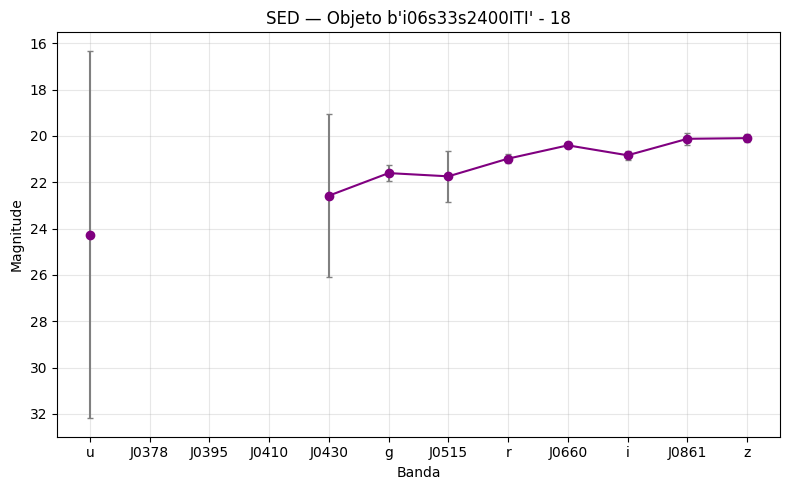

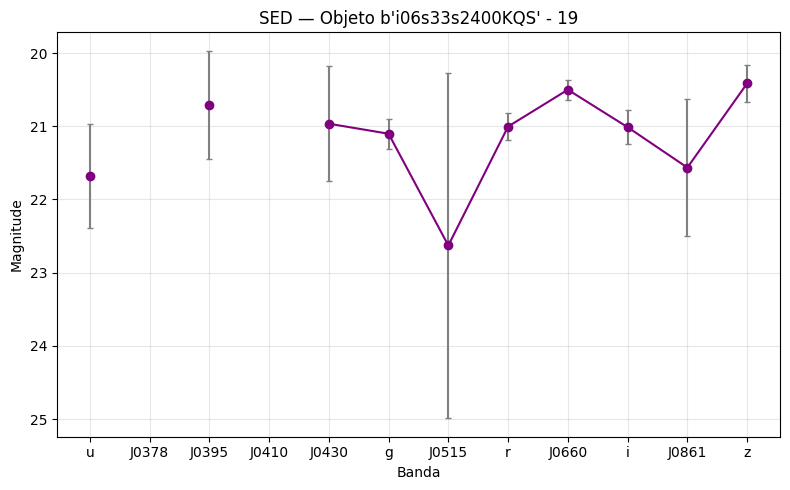

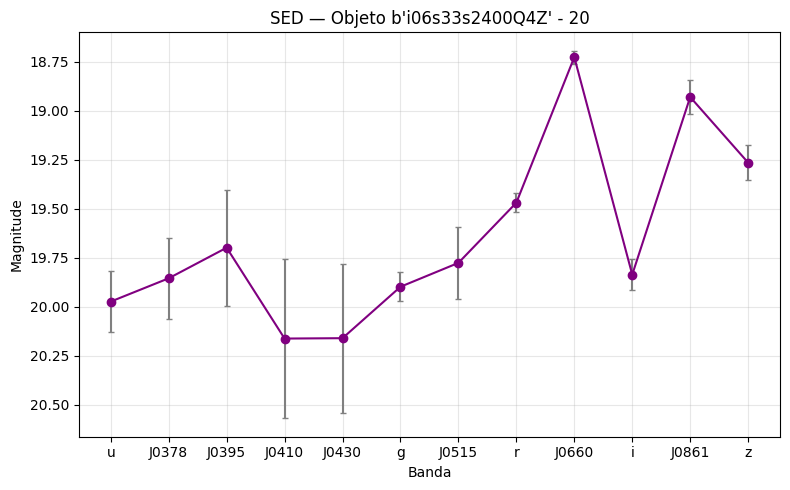

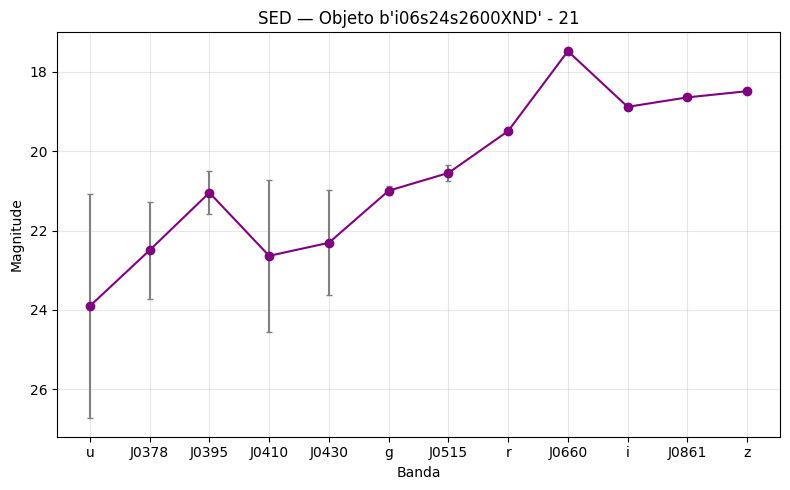

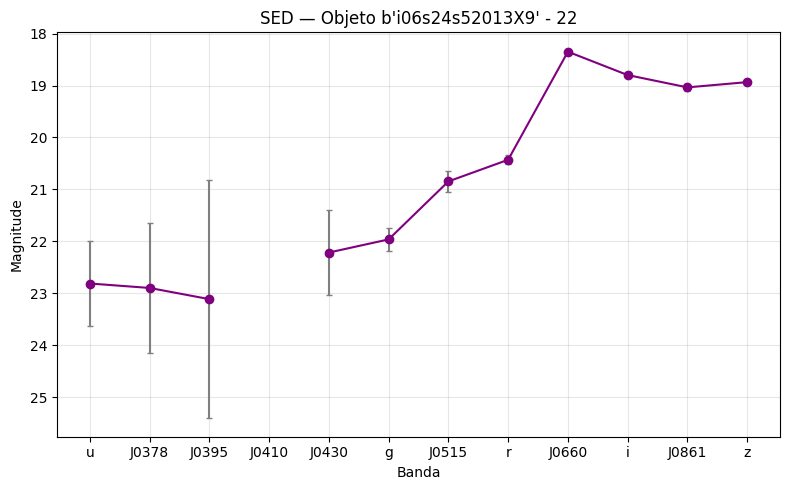

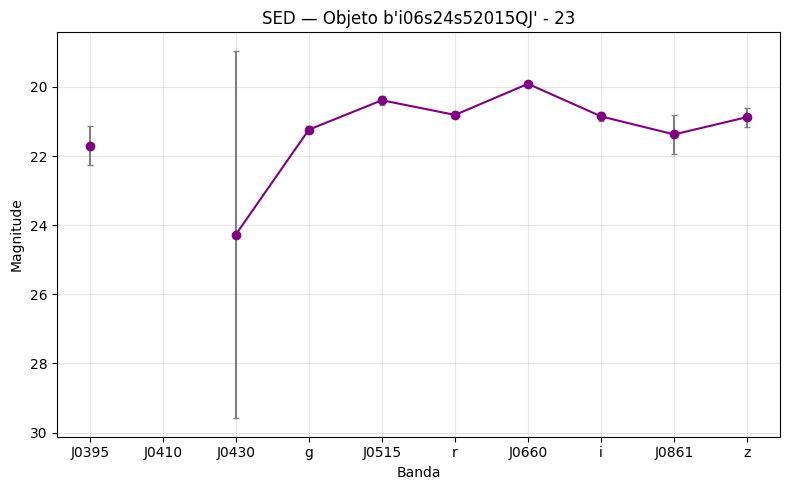

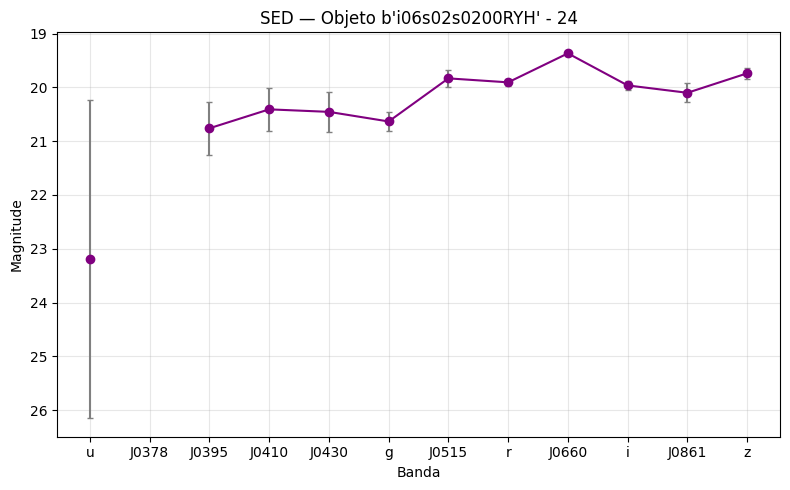

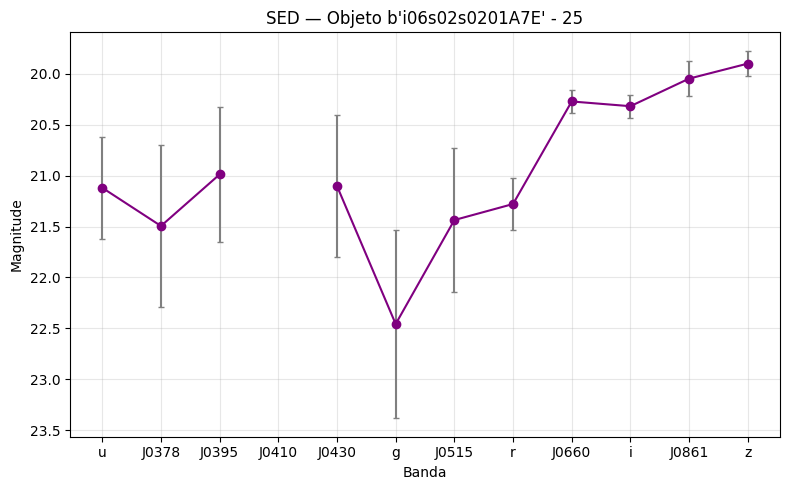

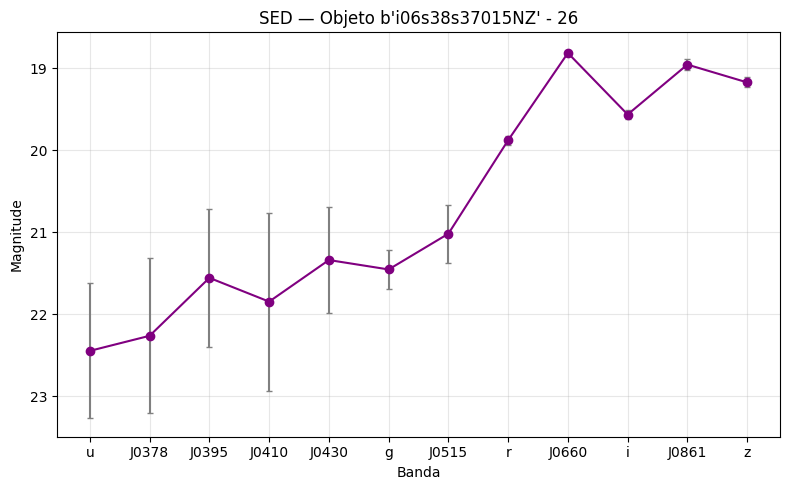

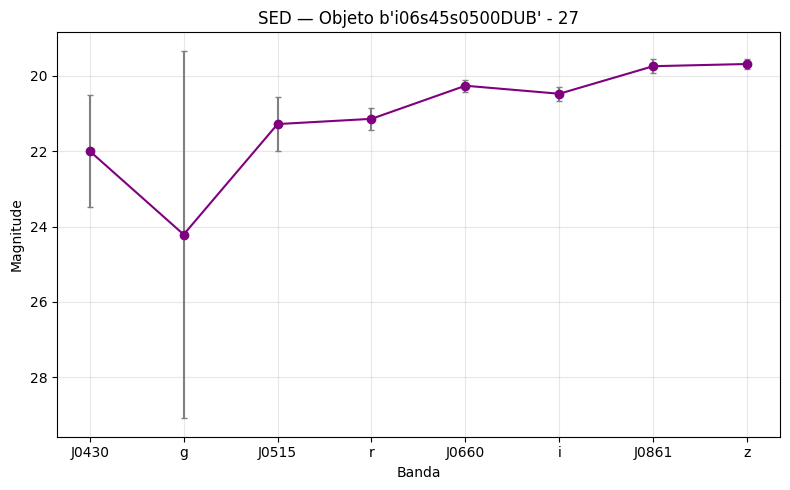

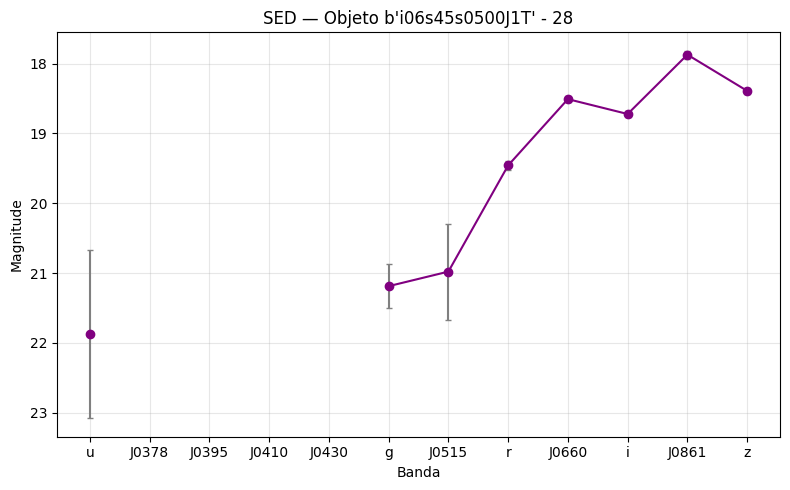

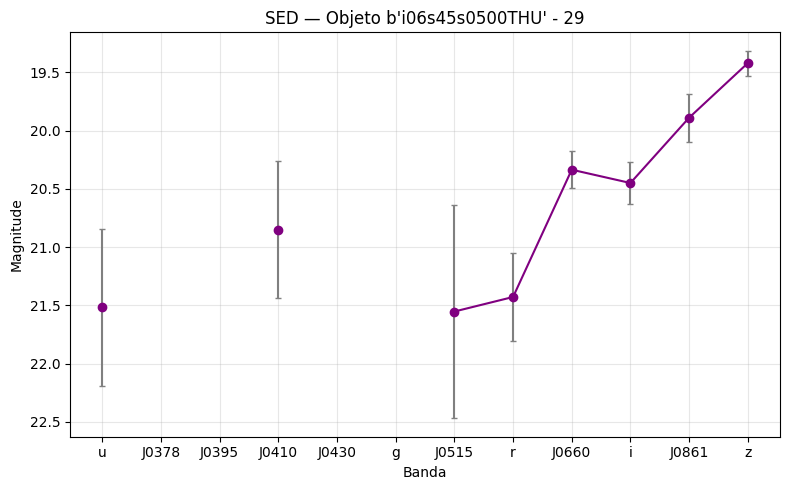

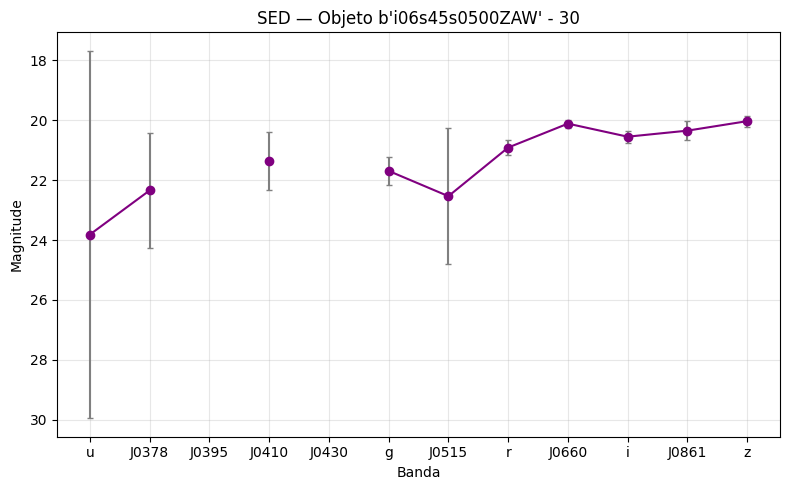

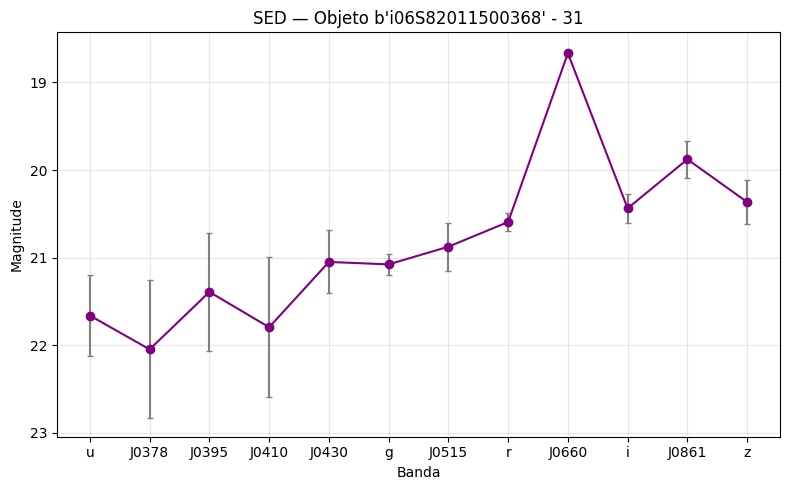

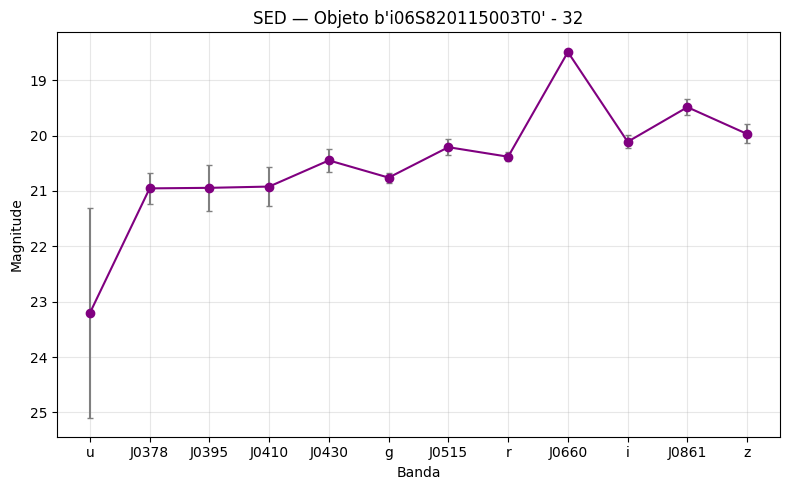

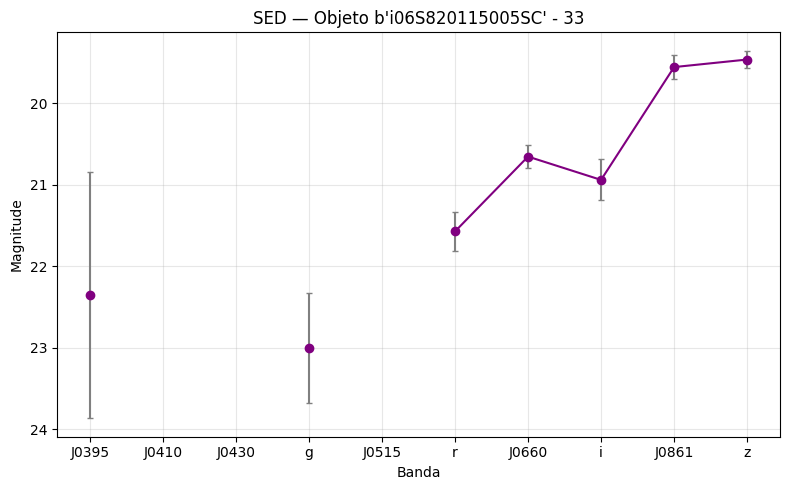

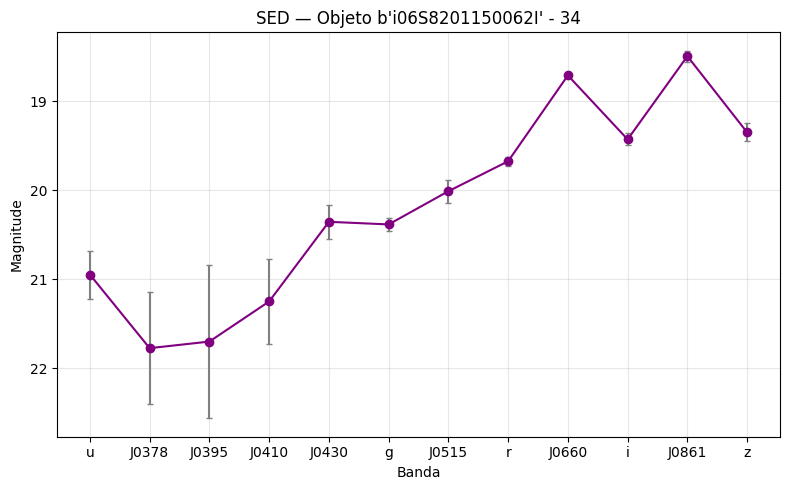

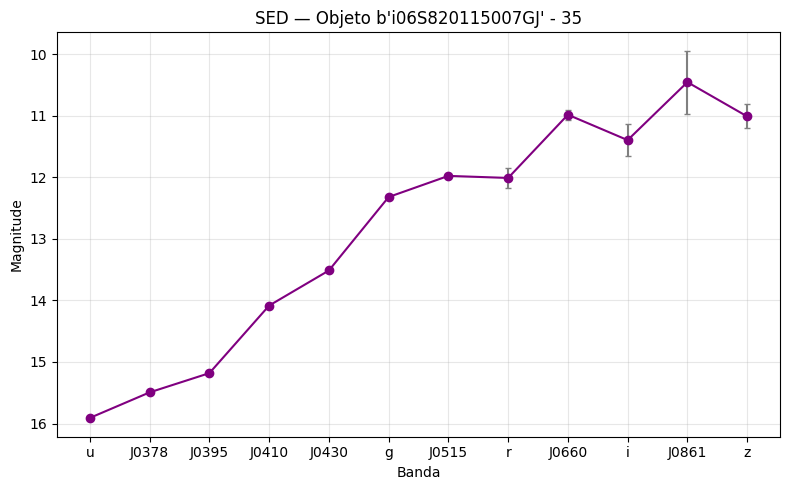

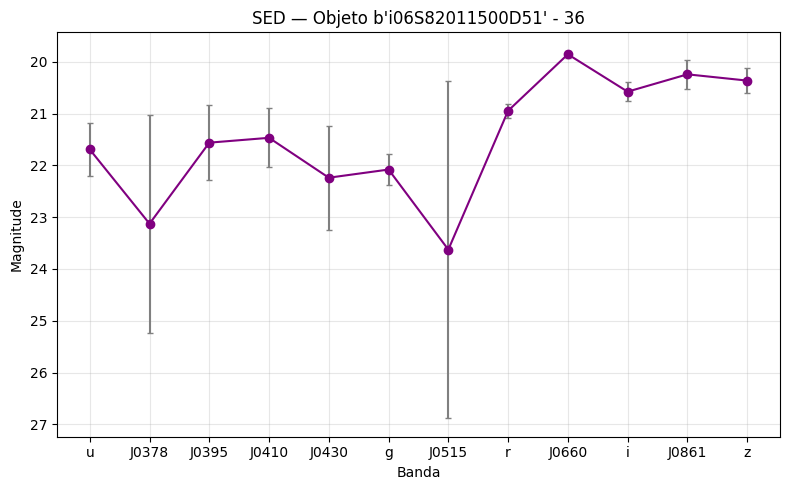

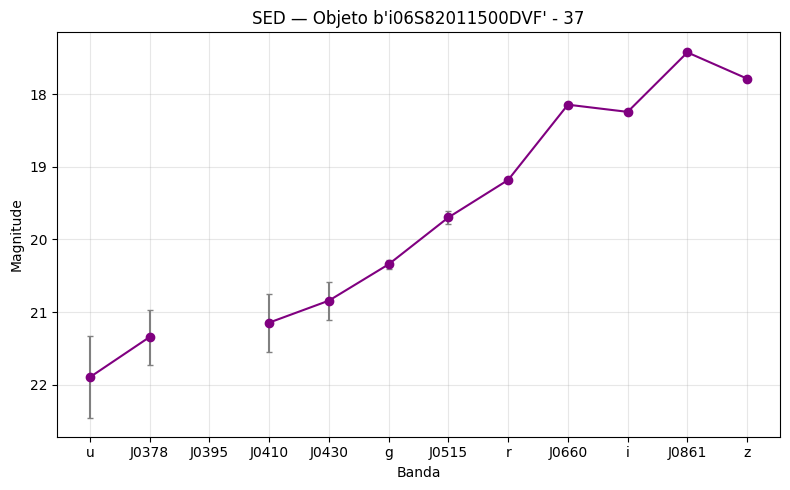

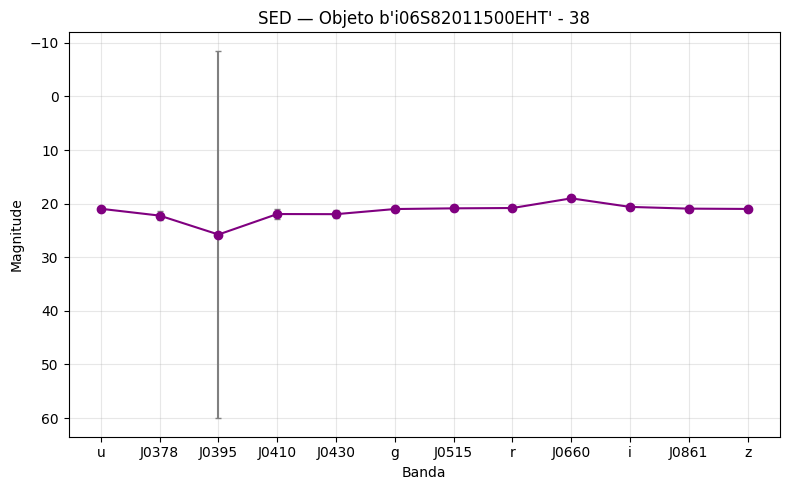

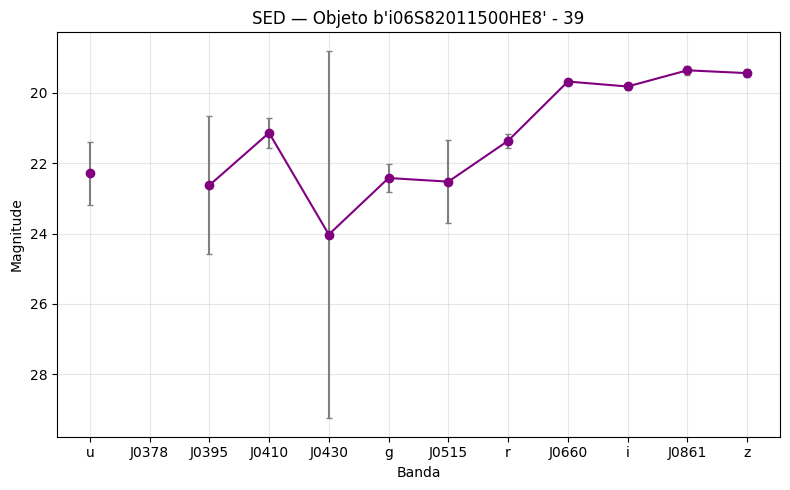

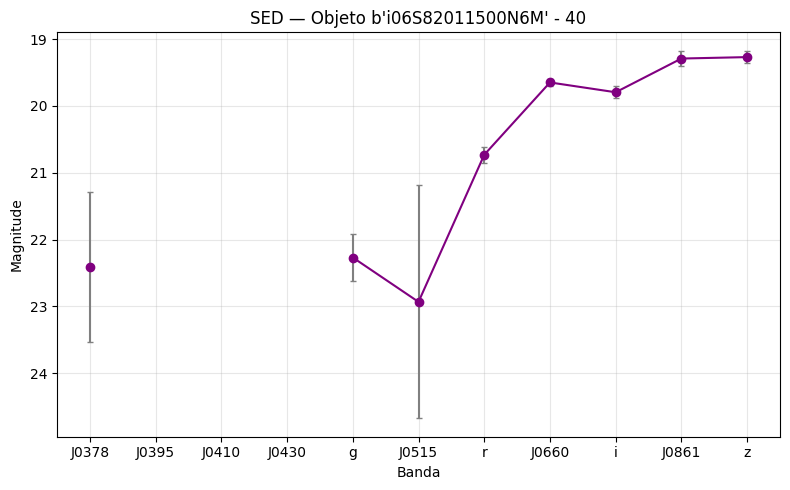

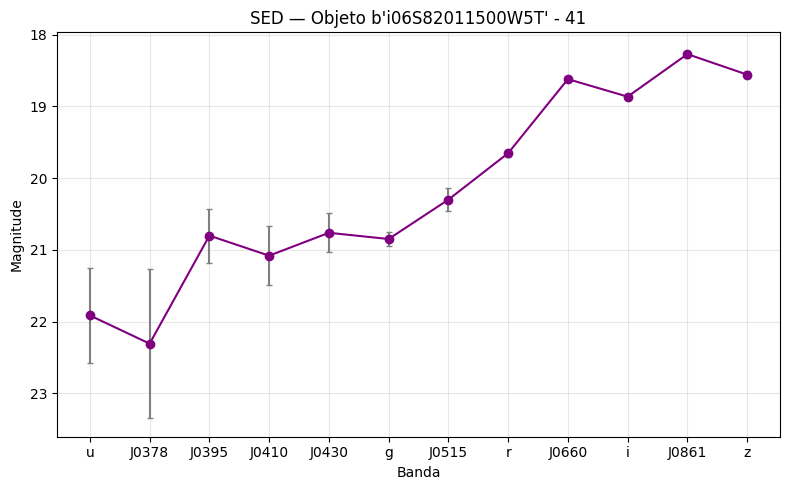

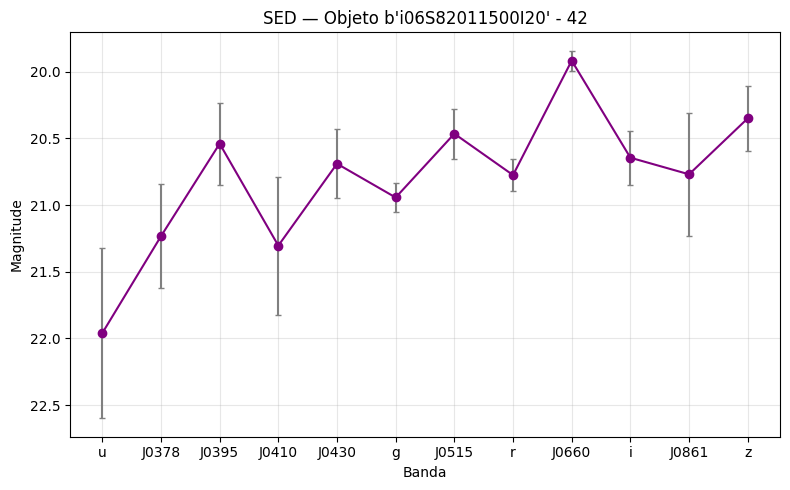

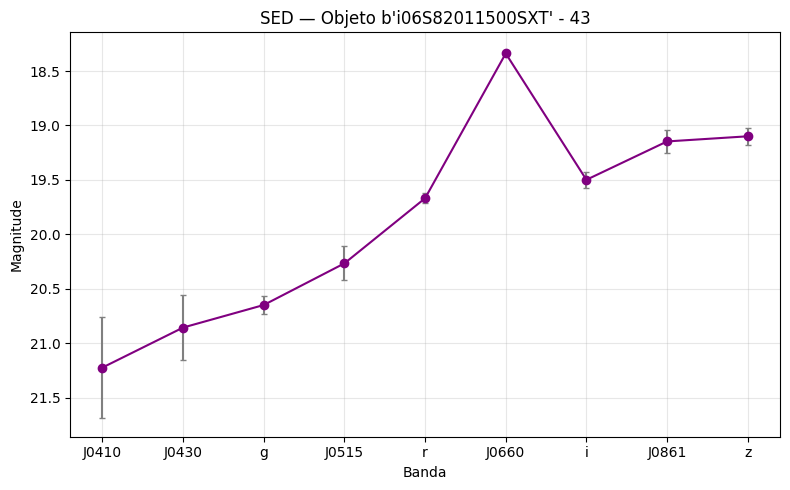

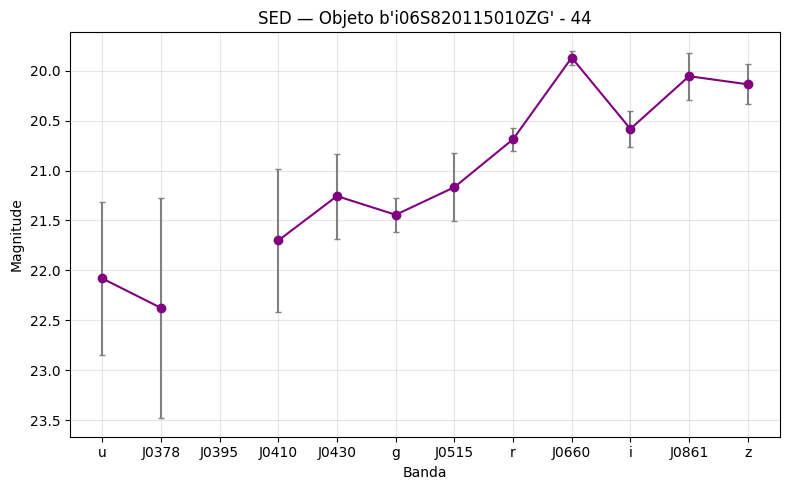

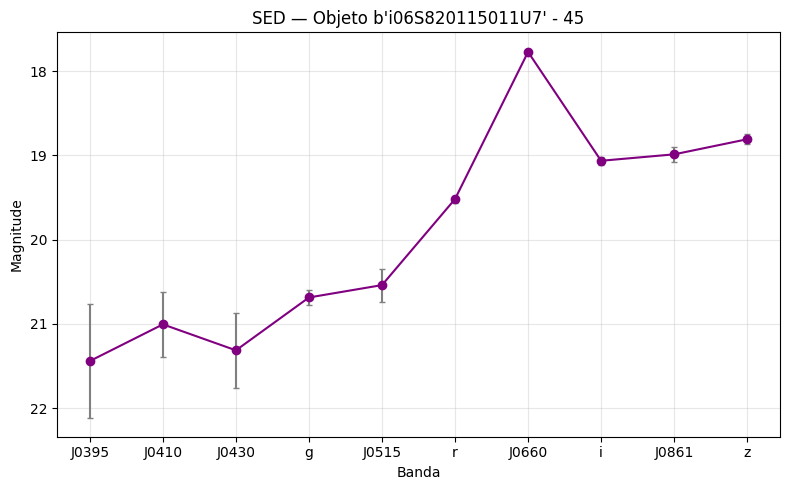

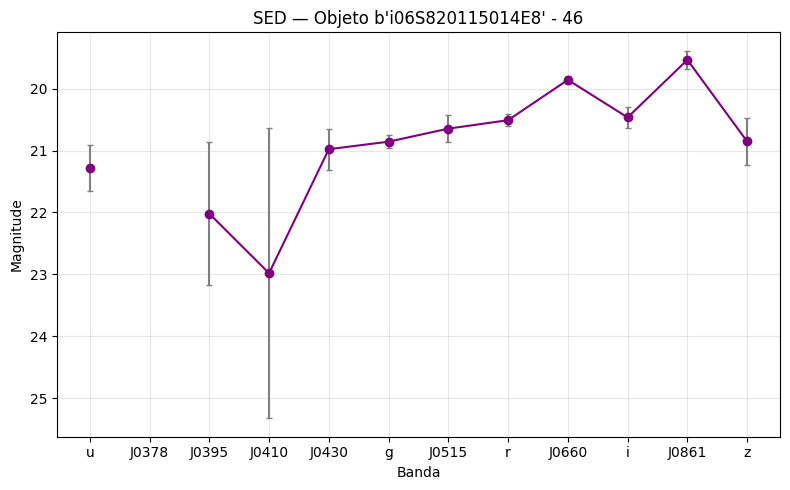

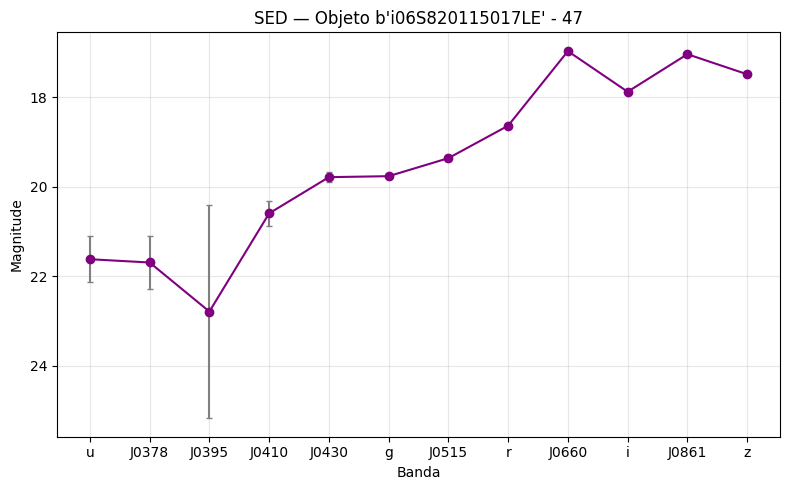

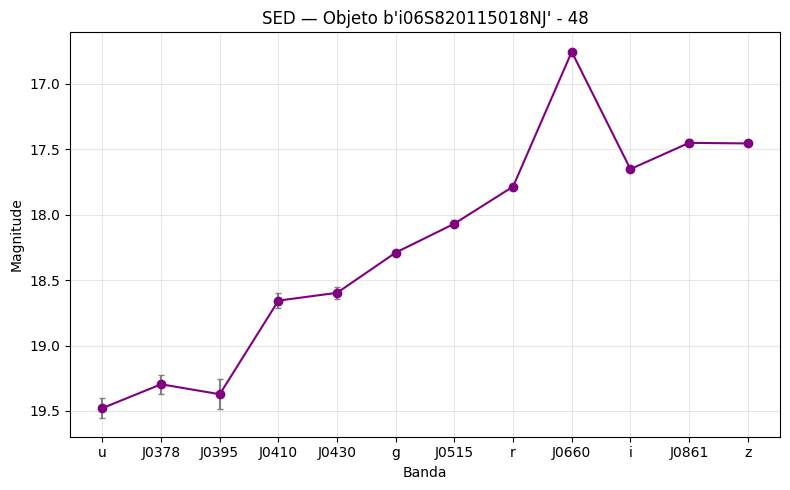

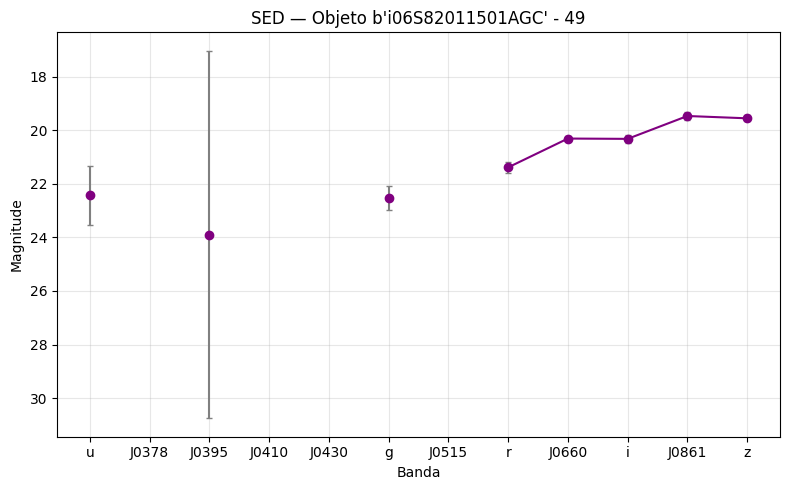

In [50]:
import numpy as np
import matplotlib.pyplot as plt

bands = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']
wavelengths = np.array([3536, 3770, 3940, 4094, 4292, 4751, 5133, 6258, 6614, 7690, 8611, 8831])

mag_cols = [f"mag_pstotal_{b.lower()}" for b in bands]
err_cols = [f"err_mag_pstotal_{b.lower()}" for b in bands]
has_errors = all(col in g_ex.columns for col in err_cols)

i = 0
for idx, row in g_ex.iterrows():
    mags = row[mag_cols].to_numpy()

    plt.figure(figsize=(8, 5))
    if has_errors:
        errs = row[err_cols].to_numpy()
        plt.errorbar(bands, mags, yerr=errs, fmt='o-', color='purple', ecolor='gray', capsize=2)
    else:
        plt.plot(bands, mags, 'o-', color='purple')

    plt.gca().invert_yaxis()
    plt.xlabel('Banda')
    plt.ylabel('Magnitude')
    plt.title(f'SED — Objeto {row["id"]} - {i}')  # <<< usar a linha atual
    # plt.title(f'SED — Objeto {row['id']} - {row['main_type']}')  # se quiser incluir o tipo

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    i += 1
    if i >= 50:
        break